Wind Power Prediction

Problem statement:
electric utility companies need reliable predictions of wind power output at least 24 hours in advance in order to better plan the requirements for other power input sources into the electrical grid.

In this project, the Spatial Dynamic Wind Power Forecasting or [SDWPF dataset](https://arxiv.org/abs/2208.04360), which contains data from 134 wind turbines in a wind farm in China was used.

# Exploratory data analysis

Import puthon Packages

In [1]:
import random
import warnings
import pandas as pd # package for reading in and manipulating the data
import seaborn as sns # package for data visualization
import ipywidgets as widgets # package for creating interactive visuals
import matplotlib.pyplot as plt # package for making plots
import numpy as np
from IPython.display import display # package for displaying visuals
from datetime import datetime, timedelta
from ipywidgets import interact, interact_manual, fixed
from typing import Iterable, Callable, List, Tuple, Dict, Optional
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn import metrics
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import shap
import tensorflow as tf
from dataclasses import dataclass
import pickle

In [2]:

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [3]:
# Load the raw data from csv file
raw_data =  pd.read_csv("./data/wtbdata_245days.csv")

# Add units to numerical features
raw_data.columns = ["TurbID", "Day", "Tmstamp", "Wspd (m/s)", "Wdir (°)", "Etmp (°C)",
                    "Itmp (°C)", "Ndir (°)", "Pab1 (°)", "Pab2 (°)", "Pab3 (°)", "Prtv (kW)", "Patv (kW)"]

the dataset contains the following information:

- `TurbID`: Wind turbine identification number.


- `Day`: The number of the day represented as a string (first day is May 1st 2020).


- `Tmstamp`: The hour and minute of the date of the measurement.


- `Wspd`: The wind speed recorded by the anemometer measured in meters per second.


- `Wdir`: The angle between the wind direction and the position of turbine nacelle measured in degrees.


- `Etmp`: Temperature of the surounding environment measured in degrees Celsius.


- `Itmp`: Temperature inside the turbine nacelle measured in degrees Celsius.


- `Ndir`: Nacelle direction, i.e., the yaw angle of the nacelle measured in degrees.


- `Pab1`: Pitch angle of blade 1 measured in degrees.


- `Pab2`: Pitch angle of blade 2 measured in degrees.


- `Pab3`: Pitch angle of blade 3 measured in degrees.


- `Prtv`: Reactive power measured in kW.


- `Patv`: Active power measured in kW → **note: this is the target variable to be predicted**.


# Missing values

In [4]:
# Missing values per feature
raw_data.isnull().sum()

TurbID            0
Day               0
Tmstamp           0
Wspd (m/s)    49518
Wdir (°)      49518
Etmp (°C)     49518
Itmp (°C)     49518
Ndir (°)      49518
Pab1 (°)      49518
Pab2 (°)      49518
Pab3 (°)      49518
Prtv (kW)     49518
Patv (kW)     49518
dtype: int64

In [5]:
# Dataframe with at least one missing values
missing_values = raw_data[raw_data.isnull().any(axis=1)]
mv = raw_data[raw_data.isnull().any(axis=1)]

# Compute missing and total values
num_null_values = len(missing_values)
total_Missing_values =  len(raw_data)
print(f"\nThe dataset contains {total_Missing_values} rows, of which {num_null_values} are missing.\n\nThis is {(num_null_values/total_Missing_values)*100:.3f}% of the total data.")


The dataset contains 4727520 rows, of which 49518 are missing.

This is 1.047% of the total data.


In [6]:
# define function to inspect missing values
def inspect_missing_values (
        mv_df: pd.core.frame.DataFrame, Num_samples: int, output: widgets.Output
):
    """Interactive dataframe to inspector to visualise missing values
Args:
    mv_df(pd.core.frame..DataFrame): Dataframe with missing values
    num_samplea(int): Number of samples to inspect at any given time
    output(widgets.Output): Output of the widget (this is for visual purpose)
    """

    def on_button_clicked(b):
        with output:
            output.clear_output()
            random_index = random.sample(range(len(mv_df)), Num_samples)
            display(mv_df.iloc[random_index].head(Num_samples))

    return on_button_clicked

In [7]:
# Display button to inspect missing values
button = widgets.Button(description="Inspect 🔍")
output = widgets.Output()
display(button, output)

# Number of sample to inspect on each click
number_sample = 5

# inspect missing value by clicking inspect button
button.on_click(inspect_missing_values(missing_values, number_sample, output))

Button(description='Inspect 🔍', style=ButtonStyle())

Output()

In [8]:
# Drop Missing values
raw_data = raw_data.dropna()

# print missing values per feature
raw_data.isnull().sum()

TurbID        0
Day           0
Tmstamp       0
Wspd (m/s)    0
Wdir (°)      0
Etmp (°C)     0
Itmp (°C)     0
Ndir (°)      0
Pab1 (°)      0
Pab2 (°)      0
Pab3 (°)      0
Prtv (kW)     0
Patv (kW)     0
dtype: int64

# Descriptive Statistics

In [9]:
# List of features
all_features = list(raw_data.columns)

# Numerical features
numerical_features = [f for f in all_features if f not in ["TurbID", "Day", "Tmstamp"]]

numerical_features = list(numerical_features)

In [10]:
# Descriptive statistics
descriptive_stats = raw_data[numerical_features].describe().transpose()

# Format to 3 decimal place
descriptive_stats.apply(lambda s: s.apply('{0:3f}'.format))

,count,mean,std,min,25%,50%,75%,max
Wspd (m/s),4678002.000000,5.028376,3.393703,0.000000,2.240000,4.340000,7.010000,26.290000
Wdir (°),4678002.000000,0.497543,31.602751,-3030.460000,-3.830000,-0.230000,3.420000,2266.950000
Etmp (°C),4678002.000000,41.106676,85.290107,-273.030000,14.050000,25.730000,32.730000,394.330000
Itmp (°C),4678002.000000,27.397169,18.328316,-273.170000,20.060000,30.080000,36.820000,324.210000
Ndir (°),4678002.000000,188.582552,163.245868,-884.860000,63.020000,194.790000,321.960000,700.620000
Pab1 (°),4678002.000000,26.854001,38.835661,-10.000000,0.010000,0.540000,83.990000,99.980000
Pab2 (°),4678002.000000,26.839158,38.829399,-10.000000,0.010000,0.540000,83.980000,99.980000
Pab3 (°),4678002.000000,26.826785,38.822347,-10.000000,0.010000,0.540000,83.980000,99.980000
Prtv (kW),4678002.000000,-13.238996,70.442443,-624.980000,-38.610000,-0.300000,-0.030000,485.200000
Patv (kW),4678002.000000,350.445751,424.993209,-9.330000,-0.300000,179.080000,547.660000,1567.020000


# Select Subset of turbines

In [13]:
# Function to select the top n turbines based on the highest average energy output
def top_n_turbines(
        raw_data: pd.core.frame.DataFrame, n: int
) -> pd.core.frame.DataFrame:
    """
    Filters the dataset to include only the top n turbines with the highest average energy output.

    Args:
        raw_data (pd.core.frame.DataFrame): The full dataset with turbine data.
        n (int): Number of top turbines to keep.

    Returns:
        pd.core.frame.DataFrame: Filtered dataset containing only the top n turbines.
    """
    # Group data by turbine ID and calculate the average energy output; sort turbines in descending order of output
    sorted_patv_by_turbine = (
        raw_data.groupby("TurbID").mean(numeric_only=True)[
            "Patv (kW)"].sort_values(ascending=False)
    )
    # Identify the top n turbines by their turbine IDs
    top_turbines = list(sorted_patv_by_turbine.index)[:n]

    # Print the size and scope of the original dataset
    print(
        f"The original dataset has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines"
    )
    # Filter the dataset to include only rows corresponding to the top n turbines
    raw_data = raw_data[raw_data["TurbID"].isin(top_turbines)]

    # Print the size and scope of the filtered dataset
    print(
        f"The sliced data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines"
    )

    # Return the filtered dataset with the top n turbines
    return raw_data

In [14]:
# Dataset for top 10 turbines
top_turbines = top_n_turbines(raw_data, 10)

The original dataset has 4678002 rows from 134 turbines
The sliced data has 349365 rows from 10 turbines


# Visualise the Data

### Histograams

A histogram is a way to investigate the distribution of the data by counting up values across a series of bins covering the range of the data. The height of each bin tells you how many datapoints fall into that bin. So the higher the bars of a histogram in a certain region, the more datapoints are there in that region.

In [15]:
FONT_SIZE_TICKS = 15
FONT_SIZE_TITLE = 25
FONT_SIZE_AXES = 20

In [16]:
# Function to create an interactive histogram plot
def histogram_plot(df: pd.core.frame.DataFrame, features: List[str], bins: int = 16):
    """
    Creates interactive histogram plots for specified features of the dataset.

    Args:
        df (pd.core.frame.DataFrame): The dataset used for the plot.
        features (List[str]): List of feature column names to include in the plot.
        bins (int, optional): Number of bins in the histogram. Default is 16.
    """

    def _plot(turbine, feature):
        """
        Helper function to generate and display a histogram for a specific turbine and feature.

        Args:
            turbine: The ID of the turbine to filter data by.
            feature: The feature to visualize in the histogram.
        """
        # Filter the data for the selected turbine
        data = df[df.TurbID == turbine]

        # Plot histogram for the selected feature
        plt.figure(figsize=(8, 5))  # Set figure size
        x = data[feature].values  # Extract values of the selected feature
        plt.xlabel(f"{feature}", fontsize=FONT_SIZE_AXES)  # Set x-axis label
        # Create histogram with specified number of bins
        sns.histplot(x, bins=bins)
        plt.ylabel("Count", fontsize=FONT_SIZE_AXES)  # Set y-axis label
        plt.title(f"Feature: {feature} - Turbine: {turbine}",
                  fontsize=FONT_SIZE_AXES)  # Set title
        # Adjust tick label sizes
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.show()  # Display the plot

    # Create a dropdown widget for selecting turbine IDs
    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(),  # Options: unique turbine IDs in the dataset
        # Default value: last turbine ID in the dataset
        value=df.TurbID.unique()[-1],
        description="Turbine"  # Label for the dropdown
    )

    # Create a dropdown widget for selecting features
    feature_selection = widgets.Dropdown(
        options=features,  # Options: list of features provided
        descriotion="Feature"  # Label for the dropdown
    )

    # Link the dropdown widgets to the `_plot` function for interactivity
    interact(_plot, turbine=turbine_selection, feature=feature_selection)

In [17]:
# Define number of bins to use
bin_size=64

# Generate histogram
histogram_plot(top_turbines, numerical_features, bin_size)

interactive(children=(Dropdown(description='Turbine', index=9, options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 70), val…

#### Histogram comparison between two turbines

In [21]:
# function for comparing histogram distributions between two turbines for numerical features in the dataset.

def histogram_comparison_plot(
        df: pd.core.frame.DataFrame, features: List[str], bins: int = 16
):
        """Create Interactive histpgram to compare tow turbines
        Args:
        df (pd.core.frame.DataFrame): The dataset used for the plot
        features (List[str]): List of features to include in the plot
        bins (int, optional): Number of bins in the histogram. Defualt is 16
         """
        # Filter the data for each turbine
        def _plot(turbine1, turbine2, feature):
                data_1 = df[df.TurbID ==turbine1]
                data_2 =  df[df.TurbID ==turbine2]

                # Create a side-by-side comparison plot
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
                x_1 = data_1[feature].values
                x_2 = data_2[feature].values

                # Set x-axis and y-axis labels for both plots
                ax1.set_xlabel(f"{feature}", fontsize=FONT_SIZE_AXES)
                ax2.set_xlabel(f"{feature}", fontsize=FONT_SIZE_AXES)

                ax1.set_ylabel(f"Count", fontsize=FONT_SIZE_AXES)
                ax2.set_ylabel(f"Count", fontsize=FONT_SIZE_AXES)

                # Plot histograms for both turbines
                sns.histplot(x_1, bins=bins, ax=ax1)
                sns.histplot(x_2, bins=bins, ax=ax2, color="green")

                # Set titles for both subplots
                ax1.set_title(f"Turbine: {turbine1}", fontsize=FONT_SIZE_TITLE)
                ax1.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

                ax2.set_title(f"Turbine: {turbine2}", fontsize=FONT_SIZE_AXES)
                ax2.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

                # Adjust layout for better appearance
                fig.tight_layout()
                fig.show()

        # Create dropdown widget for selecting the first turbine
        turbine_selection1 = widgets.Dropdown(
                options=df.TurbID.unique(),
                value=df.TurbID.unique()[-2],
                description="Turbine ID",
                style={"description_width": "initial"},
        )

        # Create dropdown widget for selecting the second turbine
        turbine_selection2 = widgets.Dropdown(
                options=df.TurbID.unique(),
                value=df.TurbID.unique()[-1],
                description="Turbine ID",
                style={"description_width": "initial"},
        )

        # Create dropdown widget for selecting the feature
        feature_selection = widgets.Dropdown(
                options=features,
                description="Features",
        )

        # Link the dropdown widgets to the `_plot` function for interactivity
        interact(
                _plot,
                turbine1=turbine_selection1,
                turbine2=turbine_selection2,
                feature=feature_selection,
        )

In [22]:
# Number of bins to use
bin_size = 32

# Generate Histogram
histogram_comparison_plot(top_turbines, numerical_features, bin_size)

interactive(children=(Dropdown(description='Turbine ID', index=8, options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 70), …

### Box plots and violin plots

Box plots and violin plots are another way of investigating the distribution of the dataset. The range of data values runs along the vertical axis and each box or violin provides on information on the distribution of the data.

In [23]:
# Function to create interactive box and violin plots
def box_violin_plot(df: pd.core.frame.DataFrame, features: List[str]):
    """
    Creates interactive box and violin plots for numerical features across turbines.

    Args:
        df (pd.core.frame.DataFrame): The dataset containing turbine data.
        features (List[str]): List of feature column names to include in the plot.
    """
    # Get unique turbine IDs for consistent ordering in the plots
    labels = df["TurbID"].unique()

    def _plot(feature="Wspd", plot_type="box"):
        """
        Helper function to generate and display box or violin plots for the selected feature.

        Args:
            feature (str): The feature to visualize.
            plot_type (str): The type of plot to create ("box" or "violin").
        """
        # Set the plot size
        plt.figure(figsize=(18, 8))
        scale = "linear"  # Set the scale for the y-axis
        plt.yscale(scale)

        # Generate the selected plot type
        if plot_type == "violin":
            # Violin plot shows the distribution and density of the feature across turbines
            sns.violinplot(
                data=df, y=feature, x="TurbID", order=labels, color="seagreen"
            )
        elif plot_type == "box":
            # Box plot shows the spread and outliers of the feature across turbines
            sns.boxenplot(data=df, y=feature, x="TurbID",
                          order=labels, color="seagreen")

        # Add titles and labels
        plt.title(f"Feature: {feature}", fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        plt.xlabel("TurbID", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

        # Display the plot
        plt.show()

    # Dropdown widget to select the feature for visualization
    feature_selection = widgets.Dropdown(
        options=features,  # Options: List of features provided
        description="Feature",  # Label for the dropdown
    )

    # Dropdown widget to select the type of plot (box or violin)
    plot_type_selection = widgets.Dropdown(
        options=["violin", "box"],  # Options: Violin or Box plot
        description="Plot Type",  # Label for the dropdown
    )

    # Link the dropdown widgets to the `_plot` function for interactive updates
    interact(
        _plot,
        feature=feature_selection,  # Feature selection input
        plot_type=plot_type_selection,  # Plot type input
    )

In [24]:
# Generate Box/violin plot accross all features

box_violin_plot(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Feature', options=('Wspd (m/s)', 'Wdir (°)', 'Etmp (°C)', 'Itmp (°…

### Scatterplots

Scatterplots are useful for looking at the relationship (or lack thereof) between two variables

When dealing with wind energy generation there is a concept called the `theoretical power curve`, which corresponds to the theoretical capacity of a turbine to produce power given a particular wind speed. 

The plot below shows (for a single turbine) the real values of active power produced for different wind speeds (colored in cyan), along the theoretical power it should be able to produce under those circumstances (colored in pink).

Below is sample theorotical power curve
<img src="data/power_curve.png" align="center">

In [26]:
# Function to create an interactive scatterplot
def scatterplot(df: pd.core.frame.DataFrame, features: List[str]):
    """
    Creates an interactive scatterplot for visualizing the relationship between two features.

    Args:
        df (pd.core.frame.DataFrame): The dataset used for the plot.
        features (List[str]): The list of features available for the X and Y axes.
    """

    # Create a clean copy of the dataset by removing rows with missing values
    df_clean = df.dropna(inplace=False)

    def _plot(turbine, var_x, var_y):
        """
        Helper function to generate and display a scatterplot for the selected turbine and features.

        Args:
            turbine: The ID of the turbine to filter data by.
            var_x (str): The feature to use for the X-axis.
            var_y (str): The feature to use for the Y-axis.
        """
        # Set the plot size
        plt.figure(figsize=(12, 6))
        # Filter the data for the selected turbine
        df_clean_2 = df_clean[df_clean.TurbID == turbine]
        x = df_clean_2[var_x].values  # Extract values for the X-axis feature
        y = df_clean_2[var_y].values  # Extract values for the Y-axis feature

        # Create the scatterplot with customized styling
        plt.plot(
            x, y,
            marker='o',  # Use circular markers
            markersize=3,  # Set marker size
            markerfacecolor="blue",  # Marker color
            markeredgewidth=0,  # No marker edge
            linestyle='',  # No line connecting markers
            alpha=0.5  # Transparency level for the markers
        )

        # Set axis labels and plot title
        plt.xlabel(var_x, fontsize=FONT_SIZE_AXES)
        plt.ylabel(var_y, fontsize=FONT_SIZE_AXES)
        plt.title(f"Scatterplot of {var_x} against {var_y}", fontsize=FONT_SIZE_TITLE)

        # Adjust the appearance of tick labels
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

        # Display the plot
        plt.show()

    # Dropdown widget for selecting the turbine ID
    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(),  # Options: unique turbine IDs in the dataset
        # Default value: last turbine ID in the dataset
        value=df.TurbID.unique()[-1],
        description="Turbine"  # Label for the dropdown
    )

    # Dropdown widget for selecting the feature for the X-axis
    x_var_selection = widgets.Dropdown(
        options=features,  # Options: list of features
        description="X-Axis",  # Label for the dropdown
    )

    # Dropdown widget for selecting the feature for the Y-axis
    y_var_selection = widgets.Dropdown(
        options=features,  # Options: list of features
        description="Y-Axis",  # Label for the dropdown
        value="Patv (kW)"  # Default value: power output
    )

    # Link the dropdown widgets to the `_plot` function for interactive updates
    interact(
        _plot,
        turbine=turbine_selection,  # Turbine selection input
        var_x=x_var_selection,  # X-axis feature selection input
        var_y=y_var_selection  # Y-axis feature selection input
    )

In [27]:
# Generate per turbine scatter plot for any two features

scatterplot(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine', index=9, options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 70), val…

### Pairplot

Sometime, it can be helpful to look simultaneously at distributions and relationships

In [28]:
# Function to create a pairplot for selected features of a specific turbine
def plot_pairplot(
    original_df: pd.core.frame.DataFrame,
    turb_id: int,
    features: List[str],
    fraction: float = 0.01
):
    """
    Creates a pairplot for selected features of a specific turbine.

    Args:
        original_df (pd.core.frame.DataFrame): The dataset containing turbine data.
        turb_id (int): The ID of the selected turbine to filter data for the plot.
        features (List[str]): List of feature column names to include in the pairplot.
        fraction (float): Proportion of the data to sample for plotting, reducing computational time.
    """

    # Filter the dataset for the selected turbine ID and the specified features
    data_single_turbine = original_df[original_df.TurbID == turb_id][features]

    # Randomly sample a fraction of the data to reduce computational complexity
    data_single_turbine = data_single_turbine.sample(frac=fraction)

    # Use Seaborn to create a pairplot for the selected features
    # Adjust label size for better readability
    with sns.plotting_context(rc={"axes.labelsize": 20}):
        # Generate pairplot for feature relationships
        sns.pairplot(data_single_turbine)

    # Display the plot
    plt.show()

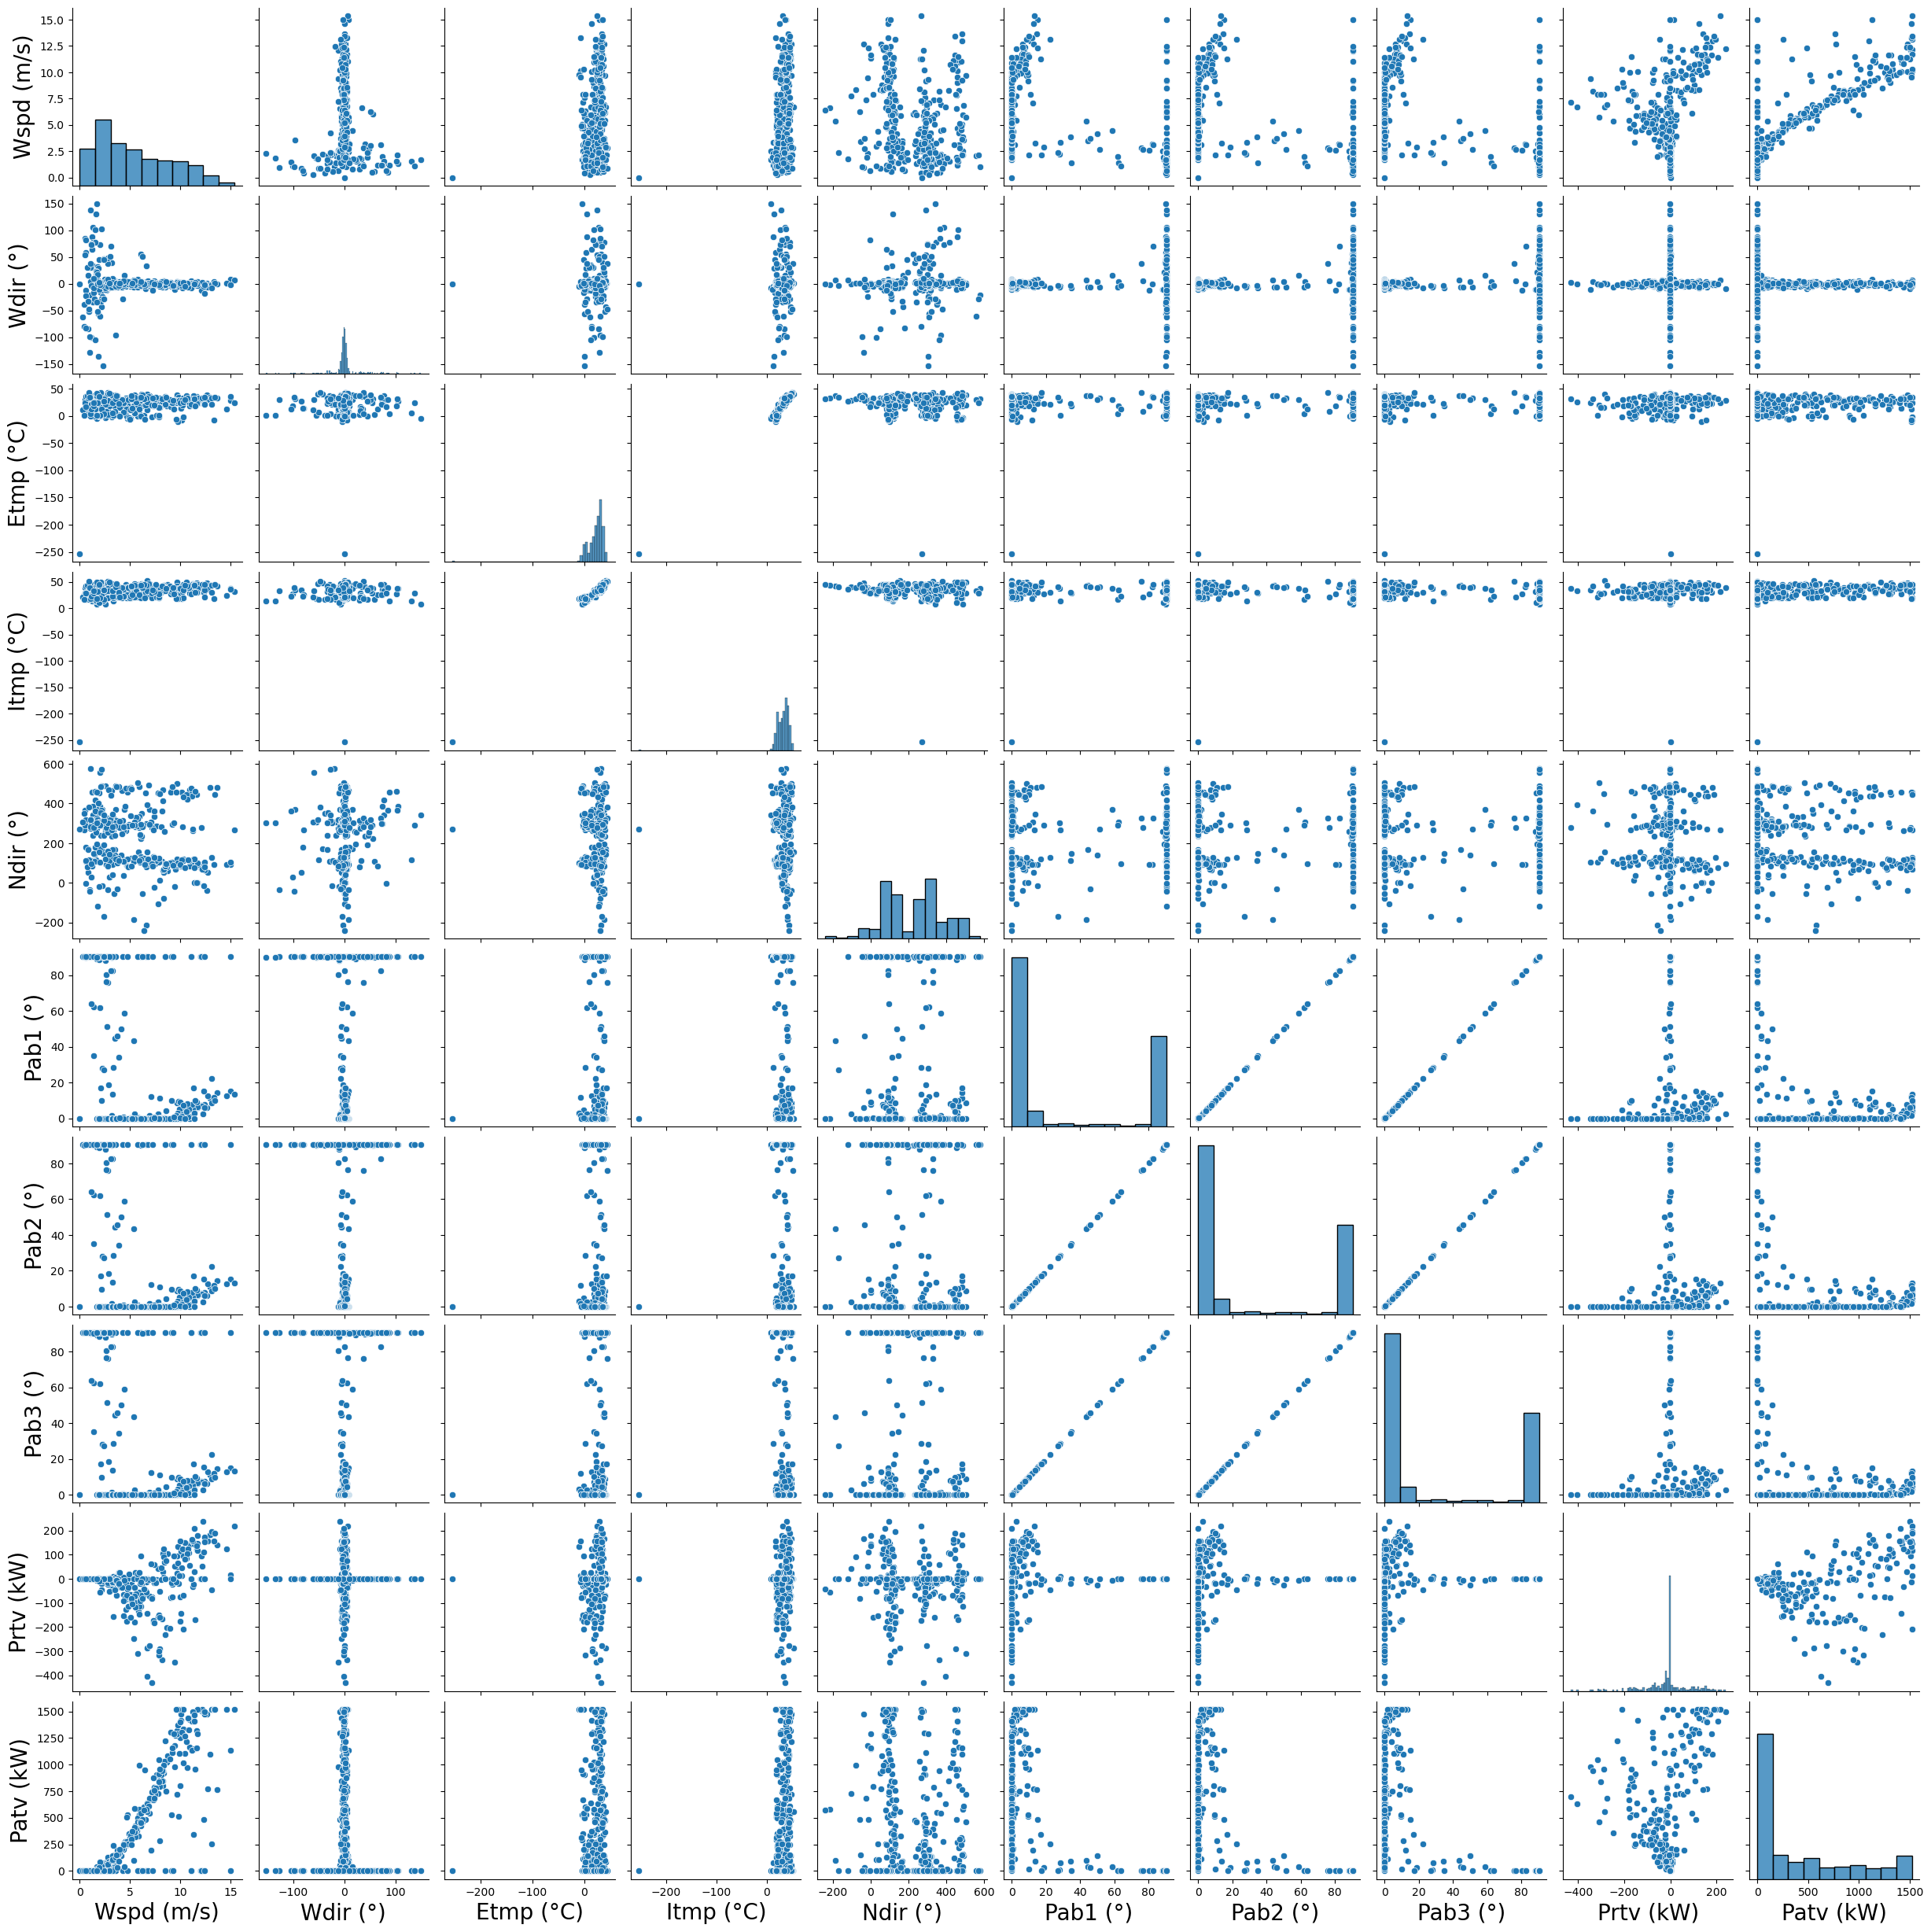

In [29]:
# Identify a turbine and fraction of data to plot (you can changes these values!)
turb_id = 6     # the id of the turbine
fraction = 0.01  # the fraction of the rows to include in the plot

plot_pairplot(top_turbines, turb_id, numerical_features, fraction)

### Correlation matrix

Correlation matrix shows how different variables correlate with each other. The [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is measured between -1 and 1. Numbers closer to 1 or -1 indicate higher levels of correlation between two variables, while values close to 0 indicate no significant correlation between two variables. 

In [30]:
# Function to plot a correlation matrix for the given dataset
def correlation_matrix(data: pd.core.frame.DataFrame):
    """
    Plots a correlation matrix for a given dataset, showing correlation values in each cell.

    Args:
        data (pd.core.frame.DataFrame): The dataset for which the correlation matrix is generated.
    """
    # Set the figure size for better readability
    plt.figure(figsize=(15, 15))  # Larger figure size for large datasets

    # Create a heatmap to visualize the correlation matrix
    sns.heatmap(
        data.corr(),            # Compute pairwise correlations between features
        annot=True,             # Display the correlation values in each cell
        fmt=".2f",              # Format the values to two decimal places
        cbar=False,             # Disable the color bar for simplicity
        cmap="RdBu",            # Use a red-to-blue colormap for clarity
        vmin=-1, vmax=1,        # Correlation values range from -1 to 1
        annot_kws={"size": 6},  # Adjust the font size of annotations
    )

    # Add a title to the plot
    plt.title("Correlation Matrix of Features")

    # Display the plot
    plt.show()

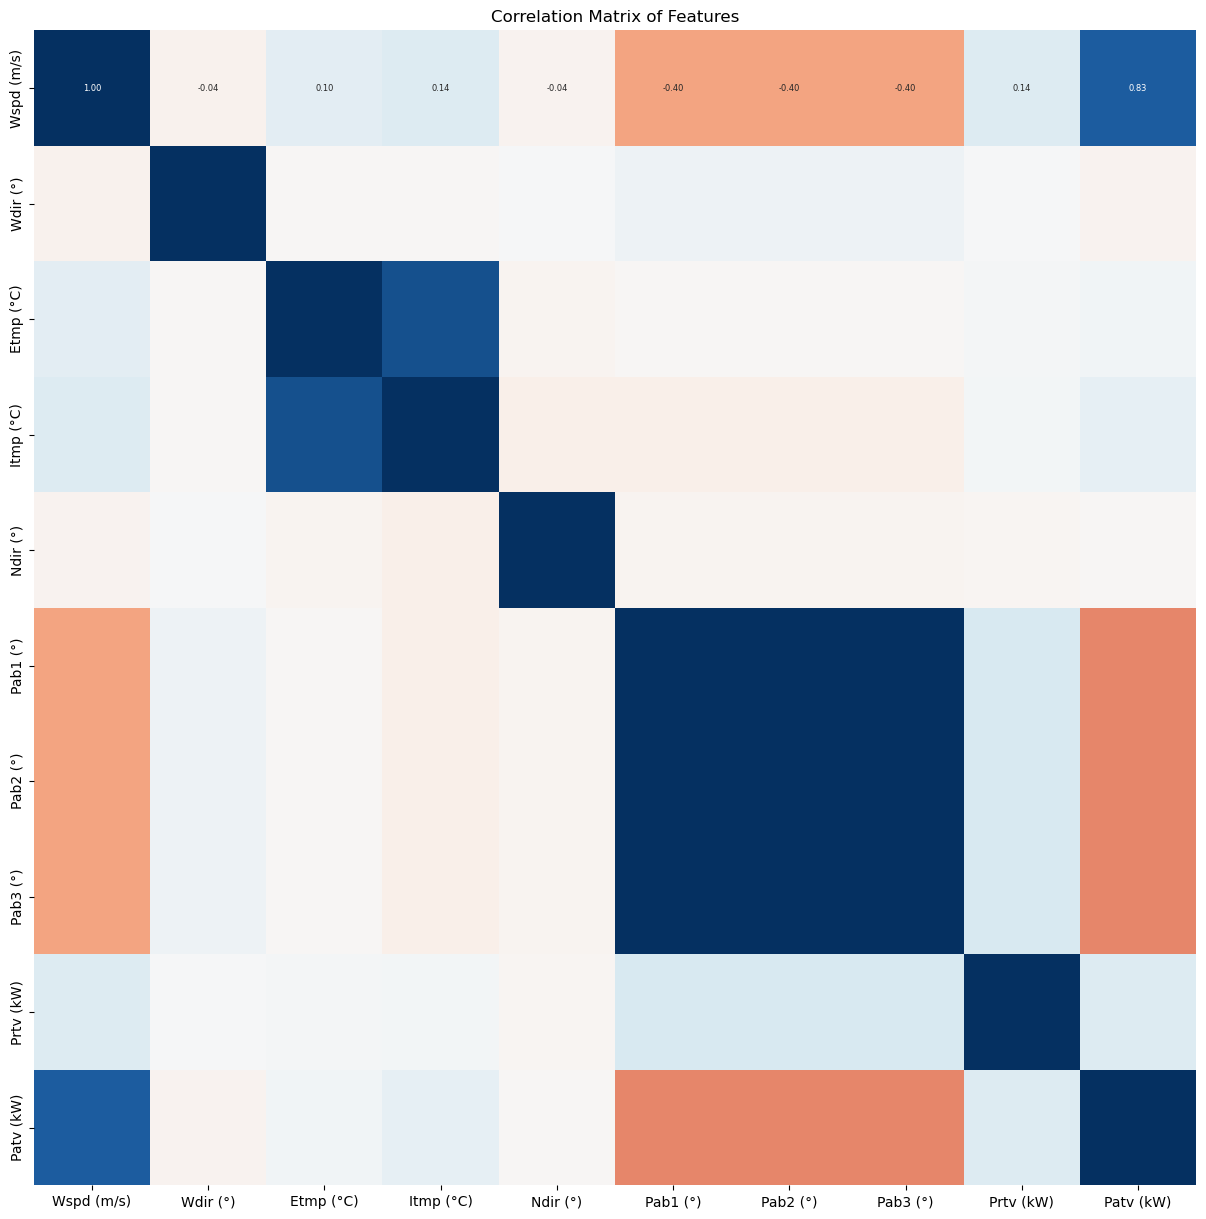

In [31]:
# Generate a corrlation matrix
correlation_matrix(top_turbines[numerical_features])

### Time Series 

#### Format date and time


The day and the time encoded as separate features. To plot a time series of the data there is the need to have a single feature with the combined "datetime" information of each record.

**The paper [SDWPF paper](https://arxiv.org/abs/2208.04360) stated that day 1 corresponds to May 1st 2020, using this information to convert day number to a proper date.**.

In [33]:
# Function to convert day number and time to a formatted datetime column
def format_datetime(df: pd.core.frame.DataFrame, initial_date_str: str
                    ) -> pd.core.frame.DataFrame:
    """
    Formats the "Day" and "Tmstamp" columns in the dataset into a unified "Datetime" column.

    Args:
        df (pd.core.frame.DataFrame): The original dataset containing "Day" and "Tmstamp" columns.
        initial_date_str (str): The starting date in the format "dd mm yyyy".

    Returns:
        pd.core.frame.DataFrame: The modified dataset with a formatted "Datetime" column.
    """
    # If the "Datetime" column already exists, return the dataset as-is
    if "DateTime" in df.columns:
        return df

    # Parse the initial date string into a datetime object
    initial_date = datetime.strptime(initial_date_str, "%d %m %Y").date()

    # Create a new "Date" column by adding the "Day" value to the initial date
    # Adjusting for zero-based indexing by subtracting 1 from "Day"
    df["Date"] = df.apply(
        lambda x: str(initial_date + timedelta(days=(x.Day - 1))), axis=1
    )

    # Combine the "Date" and "Tmstamp" columns into a unified "Datetime" column
    df["Datetime"] = df.apply(
        lambda x: datetime.strptime(f"{x.Date} {x.Tmstamp}", "%Y-%m-%d %H:%M"), axis=1
    )

    # Drop the now redundant "Day", "Tmstamp", and intermediate "Date" columns
    df.drop(["Day", "Tmstamp", "Date"], axis=1, inplace=True)

    # Reorder the columns to place "Datetime" as the first column
    df = df[["Datetime"] +
            [col for col in list(df.columns) if col != "Datetime"]]

    # Return the updated DataFrame
    return df

In [34]:
# Function to convert day number and time to datetime
def format_datetime(df: pd.core.frame.DataFrame, initial_date_str: str) -> pd.core.frame.DataFrame:
    """Formats day and tmstamt feature into a DateTime feature.

    Args:
        df (pd.core.frame.DataFrame): The original dataframe.
        initial_date_str (str): The start date in the format "dd mm yyyy".

    Returns:
        pd.core.frame.DataFrame: The dataframe with formatted datetime.
    """
    if "Datetime" in df.columns:
        return df

    # Parse the initial date
    initial_date = datetime.strptime(initial_date_str, "%d %m %Y").date()

    # Create a "Date" column by adding days to the initial date
    df["Date"] = df.apply(
        lambda x: str(initial_date + timedelta(days=(x["Day"] - 1))), axis=1
    )

    # Create the "Datetime" column by combining "Date" and "Tmstamp"
    df["Datetime"] = df.apply(
        lambda x: datetime.strptime(f"{x['Date']} {x['Tmstamp']}", "%Y-%m-%d %H:%M"), axis=1
    )

    # Drop unnecessary columns
    df.drop(["Day", "Tmstamp", "Date"], axis=1, inplace=True)

    return df

In [35]:
# Create proper datetime feature

raw_data = format_datetime(top_turbines, initial_date_str="01 05 2020")

# Plot time series

A plot of features over the time span of the data for a particular turbine.
`Etmp (°C)` and `Itmp (°C)` have really negative values. These values make it hard to visualize the actual time series for these features so there is a toggle `fix temperatures` below that you can turn on to replace these by the values produced by using a linear interpolation.

In [36]:
# Function to create an interactive time series plot for turbine data
def plot_time_series(df: pd.core.frame.DataFrame, features: List[str]):
    """
    Creates an interactive plot for visualizing time series data for a specific turbine and feature.

    Args:
        df (pd.core.frame.DataFrame): The dataset containing turbine data with a "Datetime" column.
        features (List[str]): List of features to include in the plot.
    """

    def _plot(turbine, feature, date_range, fix_temps):
        """
        Helper function to generate and display the time series plot for selected parameters.

        Args:
            turbine (int): The ID of the turbine to filter the data for.
            feature (str): The feature to plot as a time series.
            date_range (tuple): The start and end dates for filtering the time series data.
            fix_temps (bool): Whether to apply fixes to extreme temperature values.
        """
        # Filter the dataset for the selected turbine
        data = df[df.TurbID == turbine]

        # Optional: Fix extreme temperature values by replacing outliers with NaN and interpolating
        if fix_temps:
            # Fix external temperature ("Etmp (°C)")
            # Set threshold at the 1st percentile
            min_etemp = data["Etmp (°C)"].quantile(0.01)
            data["Etmp (°C)"] = data["Etmp (°C)"].apply(
                lambda x: np.nan if x < min_etemp else x
            )
            # Interpolate missing values
            data["Etmp (°C)"] = data["Etmp (°C)"].interpolate()

            # Fix internal temperature ("Itmp (°C)")
            # Set threshold at the 1st percentile
            min_itemp = data["Itmp (°C)"].quantile(0.01)
            data["Itmp (°C)"] = data["Itmp (°C)"].apply(
                lambda x: np.nan if x < min_itemp else x
            )
            # Interpolate missing values
            data["Itmp (°C)"] = data["Itmp (°C)"].interpolate()

        # Filter data for the specified date range
        data = data[data.Datetime > date_range[0]]
        data = data[data.Datetime < date_range[1]]

        # Plot the time series for the selected feature
        plt.figure(figsize=(15, 5))
        plt.plot(data["Datetime"], data[feature], "-")
        plt.title(f"Time series of {feature}", fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        plt.xlabel("Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.show()

    # Dropdown widget for turbine selection
    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(),  # Unique turbine IDs in the dataset
        values=df.TurbID.unique()[-1],  # Default to the last turbine ID
        description="Turbine ID",  # Label for the dropdown
    )

    # Dropdown widget for feature selection
    feature_selection = widgets.Dropdown(
        options=features,  # Features available for plotting
        description="Features",  # Label for the dropdown
    )

    # Date range slider for selecting start and end dates
    dates = pd.date_range(datetime(2020, 5, 1), datetime(
        2020, 12, 31), freq="D")  # Predefined date range
    options = [(date.strftime("%b %d"), date)
               for date in dates]  # Format dates as options
    index = (0, len(options) - 1)  # Default to full date range

    date_slider_selection = widgets.SelectionRangeSlider(
        options=options,  # Slider options based on the date range
        index=index,  # Default selected range
        description="Date (2020)",  # Label for the slider
        orientation="horizontal",  # Horizontal layout
        layout={"width": "550px"},  # Slider width
    )

    # Checkbox widget for fixing extreme temperature values
    fix_temps_button = widgets.Checkbox(
        value=False,  # Default to not fixing temperatures
        description="Fix Temperature",  # Label for the checkbox
        disabled=False,  # Allow user interaction
    )

    # Link the interactive widgets to the `_plot` function
    interact(
        _plot,
        turbine=turbine_selection,  # Turbine selection input
        feature=feature_selection,  # Feature selection input
        date_range=date_slider_selection,  # Date range input
        fix_temps=fix_temps_button,  # Fix temperature option input
    )

In [37]:
# Generate a time series plot of features for a paricular turbine
plot_time_series(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine ID', options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 70), value=1),…

####  Time Series for a pair of turbines

In [40]:
# Function to create interactive time series plots for a pair of turbines
def time_series_turbine_pair(original_df: pd.core.frame.DataFrame, features: List[str]):
    """
    Creates interactive time series plots to compare selected features for a pair of turbines.

    Args:
        original_df (pd.core.frame.DataFrame): The dataset containing turbine data.
        features (List[str]): List of features to include in the plots.
    """

    def plot_time_series(turbine_1, turbine_2, feature, date_range, fix_temps):
        """
        Helper function to generate and display time series plots for two turbines.

        Args:
            turbine_1 (int): ID of the first turbine.
            turbine_2 (int): ID of the second turbine.
            feature (str): The feature to plot.
            date_range (tuple): Start and end dates for filtering the data.
            fix_temps (bool): Whether to fix extreme temperature values.
        """
        # Create a copy of the dataset if temperature fixing is enabled
        df = original_df
        if fix_temps:
            df_2 = original_df.copy(deep=True)

            # Fix external temperature ("Etmp (°C)") by interpolating extreme values
            min_etemp = df_2["Etmp (°C)"].quantile(0.01)
            df_2["Etmp (°C)"] = df_2["Etmp (°C)"].apply(
                lambda x: np.nan if x < min_etemp else x
            )
            df_2["Etmp (°C)"] = df_2["Etmp (°C)"].interpolate()

            # Fix internal temperature ("Itmp (°C)") similarly
            min_itemp = df_2["Itmp (°C)"].quantile(0.01)
            df_2["Itmp (°C)"] = df_2["Itmp (°C)"].apply(
                lambda x: np.nan if x < min_itemp else x
            )
            df_2["Itmp (°C)"] = df_2["Itmp (°C)"].interpolate()
            df = df_2

        # Filter data for the first turbine and the selected date range
        data_1 = df[df.TurbID == turbine_1]
        data_1 = data_1[data_1.Datetime > date_range[0]]
        data_1 = data_1[data_1.Datetime < date_range[1]]

        # Filter data for the second turbine and the selected date range
        data_2 = df[df.TurbID == turbine_2]
        data_2 = data_2[data_2.Datetime > date_range[0]]
        data_2 = data_2[data_2.Datetime < date_range[1]]

        # Create a subplot to display time series for both turbines
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
        ax1.plot(data_1["Datetime"], data_1[feature], "-")
        ax1.set_title(f"Time series of {feature} for turbine {turbine_1}", fontsize=FONT_SIZE_TITLE)
        ax2.plot(data_2["Datetime"], data_2[feature], "-", c="green")
        ax2.set_title(f"Time series of {feature} for turbine {turbine_2}", fontsize=FONT_SIZE_TITLE)
        ax1.set_ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        ax2.set_ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        ax1.set_xlabel("Date", fontsize=FONT_SIZE_AXES)
        ax2.set_xlabel("Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.tight_layout()
        plt.show()

    # Dropdown widget for selecting the first turbine
    turbine_selection_1 = widgets.Dropdown(
        options=original_df.TurbID.unique(),  # Unique turbine IDs in the dataset
        # Default: second-to-last turbine ID
        value=original_df.TurbID.unique()[-2],
        description="1st Turbine ID",
    )

    # Dropdown widget for selecting the second turbine
    turbine_selection_2 = widgets.Dropdown(
        options=original_df.TurbID.unique(),
        value=original_df.TurbID.unique()[-1],  # Default: last turbine ID
        description="2nd Turbine ID",
        style={"description_width": "initial"},
    )

    # Dropdown widget for selecting the feature to plot
    feature_selection = widgets.Dropdown(
        options=features,  # Features available for plotting
        description="Feature",
    )

    # Checkbox widget for enabling or disabling temperature fixing
    fix_temps_button = widgets.Checkbox(
        value=False, description="Fix Temperatures", disabled=False
    )

    # Slider widget for selecting the date range
    dates = pd.date_range(datetime(2020, 5, 1), datetime(
        2020, 12, 31), freq="D")  # Predefined date range
    options = [(date.strftime("%b %d"), date) for date in dates]
    index = (0, len(options) - 1)

    date_slider_selection = widgets.SelectionRangeSlider(
        options=options,  # Slider options based on the date range
        index=index,  # Default: full date range
        description="Date (2020)",
        orientation="horizontal",
        layout={"width": "550px"},
    )

    # Link the widgets to the `plot_time_series` function for interactivity
    interact(
        plot_time_series,
        turbine_1=turbine_selection_1,
        turbine_2=turbine_selection_2,
        feature=feature_selection,
        date_range=date_slider_selection,
        fix_temps=fix_temps_button,
    )

In [41]:
# Generate a time series plot of features for a pair of turbines
time_series_turbine_pair(top_turbines, numerical_features)

interactive(children=(Dropdown(description='1st Turbine ID', index=8, options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 7…

3. Catalog abnormal values
4. Establish a baseline for wind energy estimation
5. Perform feature engineering \
    5.1 Delete redundant features - Pab \
    5.2 Transform angle features \
    5.3 Fix temperatures and active power features \
    5.4 Create time features
6. Update linear model baseline with more features
7. Use a neural network to improve wind power estimation

In [43]:
# Function to filter the dataset to include only the top n turbines based on average energy output
def top_n_turbines_new(
        raw_data: pd.core.frame.DataFrame, n: int
) -> pd.core.frame.DataFrame:
    """
    Keeps only the top n turbines that produce the most energy on average.

    Args:
        raw_data (pd.core.frame.DataFrame): The complete dataset containing turbine data.
        n (int): The number of top turbines to retain.

    Returns:
        pd.core.frame.DataFrame: The dataset containing only the top n turbines.
    """
    # Calculate the average energy output ("Patv") for each turbine and sort turbines by their average output
    sorted_patv_by_turbine = (
        raw_data.groupby("TurbID").mean(numeric_only=True)[  # Group data by turbine ID
            "Patv"  # Calculate the average energy output
            # Sort turbines in descending order of average energy output
        ].sort_values(ascending=False)
    )

    # Identify the IDs of the top n turbines
    top_turbines = list(sorted_patv_by_turbine.index)[:n]

    # Print details about the original dataset
    print(
        f"The original dataset has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines"
    )

    # Filter the dataset to include only rows for the top n turbines
    raw_data = raw_data[raw_data["TurbID"].isin(top_turbines)]

    # Print details about the filtered dataset
    print(
        f"The sliced data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines"
    )

    # Return the filtered dataset
    return raw_data

In [44]:
# Load the data from csv file

raw_data = pd.read_csv("./data/wtbdata_245days.csv")

# Drop Missing values
raw_data = raw_data.dropna()


# select the top 10 turbines

top_turbines = top_n_turbines_new(raw_data, 10)

# Format datetime (this takes around 15 secs)
top_turbines = format_datetime(
    top_turbines, initial_date_str="01 05 2020")

top_turbines.head()

The original dataset has 4678002 rows from 134 turbines
The sliced data has 349365 rows from 10 turbines


,TurbID,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Datetime
1,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,2020-05-01 00:10:00
2,1,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,2020-05-01 00:20:00
3,1,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,2020-05-01 00:30:00
4,1,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,2020-05-01 00:40:00
5,1,6.10,-1.03,30.47,41.22,20.91,1.0,1.0,1.0,-0.27,482.21,2020-05-01 00:50:00


# Catalog abnormal values

from analysis of the dataset, some values should be excluded from the analysis because they are either `missing`, `unknown` or `abnormal`. 

`missing` values are self explanatory but here are the definitions for the other two types:

`unknown`:
- if `Patv` ≤ 0 and `Wspd` > 2.5
- if `Pab1` > 89° or `Pab2` > 89° or `Pab3` > 89° 

`abnormal`:
- if `Ndir` < -720 or `Ndir` > 720
- if `Wdir` < -180 or `Wdir` > 180

In [45]:
# Function to tag abnormal values in a dataset based on a condition
def tag_abnormal_value(
        df: pd.core.frame.DataFrame, condition: pd.core.series.Series
) -> pd.core.frame.DataFrame:
    """
    Tags records in a dataset as abnormal based on a given condition.

    Args:
        df (pd.core.frame.DataFrame): The dataset to process.
        condition (pd.core.series.Series): A boolean Series where True indicates the record meets the condition for being abnormal.

    Returns:
        pd.core.frame.DataFrame: The updated dataset with tagged abnormal values.
    """
    # Identify the indexes of rows that meet the condition for being abnormal
    indexes = df[condition].index

    # Update the "Include" column to False for abnormal values
    # (Assumes "Include" is a column in the dataset used to track valid records)
    df.loc[indexes, "Include"] = False

    # Return the updated dataset
    return df

In [46]:
# Initially include all row
top_turbines["Include"] =True

# Define condition for abnormality

conditions = [
    np.isnan(top_turbines.Patv),
    (top_turbines.Pab1 > 89) | (top_turbines.Pab2 > 89) | (top_turbines.Pab3 > 89),
    (top_turbines.Ndir < -720) | (top_turbines.Ndir > 720),
    (top_turbines.Wdir < -180) | (top_turbines.Wdir > 180),
    (top_turbines. Patv <= 0) & (top_turbines.Wspd > 2.5)
]

# Exclude abnormal feature
for condition in conditions:
    top_turbines = tag_abnormal_value(top_turbines, condition)

In [47]:
# clean the dataset of abnormal values
clean_data = top_turbines[top_turbines.Include].drop(["Include"], axis=1)

## 4. Establish a baseline for wind power estimation

create a baseline for wind power estimation using a `linear regression` model to fit the relationship between wind speed and power output.


In [48]:
#function to plot wind speed vs power
def plot_wind_speed_vs_power(
    ax: plt.Axes,
    x1: Iterable,
    y1: Iterable,
    x2: Iterable,
    y2: Iterable
):
    """Plots wind speed on x-axis and wind power on y axis.

    Args:
        ax (mpl.axes._subplots.AxesSubplot): Axis on which to plot.
        x1, y1: The x, y original data to be plotted. Both can be None if not available.
        x2, y2: The x, y data model to be plotted. Both can be None if not available.
    """
    # Plot the original data
    ax.scatter(
        x1, y1, color="blue", edgecolors="white", s=15, label="actual"
    )
    # Plot the model
    ax.scatter(
        x2, y2,
        color="orange", edgecolors="black", s=15, marker="D", label="model"
    )
    ax.set_xlabel("Wind Speed (m/s)", fontsize=FONT_SIZE_AXES)
    ax.set_ylabel("Active Power (kW)", fontsize=FONT_SIZE_AXES)
    ax.set_title("Wind Speed vs. Power Output", fontsize=FONT_SIZE_TITLE)
    ax.tick_params(labelsize=FONT_SIZE_TICKS)
    ax.legend(fontsize=FONT_SIZE_TICKS)

In [49]:
# Function to plot preducted and real
def plot_predicted_vs_real(
    ax: plt.Axes,
    x1: Iterable,
    y1: Iterable,
    x2: Iterable,
    y2: Iterable
):
    """Plots predicted vs. actual data.

    Args:
        ax (mpl.axes._subplots.AxesSubplot): Axis on which to plot.
        x1, y1: The x, y original data to be plotted. Both can be None if not available.
        x2, y2: The x, y data to plot a line. Both can be None if not available.
    """
    # Plot predicted vs real y
    ax.scatter(
        x1, y1, color="orange", edgecolors="black", label="Predicted vs. actual values", marker="D"
    )
    # Plot straight line
    ax.plot(
        x2, y2, color="blue", linestyle="--", linewidth=4, label="actual = predicted",
    )
    ax.set_xlabel("Actual Power Values (kW)", fontsize=FONT_SIZE_AXES)
    ax.set_ylabel("Predicted Power Values (kW)", fontsize=FONT_SIZE_AXES)
    ax.set_title("Predicted vs. Actual Power Values (kW)",
                 fontsize=FONT_SIZE_TITLE)
    ax.tick_params(labelsize=FONT_SIZE_TICKS)
    ax.legend(fontsize=FONT_SIZE_TICKS)

In [50]:
# function to fit and plot a liner model 
def fit_and_plot_linear_model(data_og: pd.core.frame.DataFrame, turbine: int, features: List[str]):
    # Get the data for the selected turbine
    data = data_og[data_og.TurbID == turbine]

    # Create the linear regression model
    features = list(features)
    y = data["Patv"]
    X = data[features]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    reg = LinearRegression().fit(X_train, y_train)

    # Prepare the data for plotting
    X_plot = data["Wspd"]
    Y_real = data["Patv"]
    y_test_preds = reg.predict(X_test)

    X_eq_Y = np.linspace(0, max([max(y_test), max(y_test_preds)]), 100)

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # Plotting on the left side plot
    if "Wspd" in features:
        plot_wind_speed_vs_power(
            ax1, X_plot, Y_real, X_test["Wspd"], y_test_preds)
    else:
        plot_wind_speed_vs_power(ax1, X_plot, Y_real, None, None)
        print("The model could not be plotted here as Wspd is not among the features")
    # Plotting on the right side plot
    plot_predicted_vs_real(ax2, y_test, y_test_preds, X_eq_Y, X_eq_Y)

    plt.tight_layout()
    plt.show()

    # Create a plot of feature imporance if there is more than one feature
    if len(features) > 1:
        # Create data for feature importance
        bunch = permutation_importance(
            reg, X_test, y_test, n_repeats=10, random_state=42
        )
        imp_means = bunch.importances_mean
        ordered_imp_means_args = np.argsort(imp_means)[::-1]

        results = {}
        for i in ordered_imp_means_args:
            name = list(X_test.columns)[i]
            imp_score = imp_means[i]
            results.update({name: [imp_score]})

        results_df = pd.DataFrame.from_dict(results)

        # Create a plot for feature importance
        fig, ax = plt.subplots(figsize=(7.5, 6))
        ax.set_xlabel("Importance Score", fontsize=FONT_SIZE_AXES)
        ax.set_ylabel("Feature", fontsize=FONT_SIZE_AXES)
        ax.set_title("Feature Importance", fontsize=FONT_SIZE_TITLE)
        ax.tick_params(labelsize=FONT_SIZE_TICKS)

        sns.barplot(data=results_df, orient="h", ax=ax,
                    color="deepskyblue", width=0.3)

        plt.show()

    # Print out the mean absolute error
    mae = metrics.mean_absolute_error(y_test, y_test_preds)
    print(f"Turbine {turbine}, Mean Absolute Error (kW): {mae:.2f}\n")

In [51]:
# Function to create an interactive linear univariate model for energy output prediction
def linear_univariate_model(data_og: pd.core.frame.DataFrame):
    """
    Creates an interactive plot of a univariate linear model for predicting energy output 
    using wind speed as the sole predictor.

    Args:
        data_og (pd.core.frame.DataFrame): The dataset containing turbine data.
    """
    # Dropdown widget for selecting a specific turbine
    turbine_selection = widgets.Dropdown(
        options=data_og.TurbID.unique(),  # Unique turbine IDs in the dataset
        description="Turbine",  # Label for the dropdown
    )

    # Interactive function linking the dropdown widget to the `fit_and_plot_linear_model` function
    interact(
        fit_and_plot_linear_model,  # Function to fit and plot the linear model
        data_og=fixed(data_og),  # Pass the dataset as a fixed argument
        turbine=turbine_selection,  # Turbine selection input
        # Use "Wspd" (wind speed) as the fixed predictor feature
        features=fixed(["Wspd"])
    )

In [52]:
linear_univariate_model(clean_data)

interactive(children=(Dropdown(description='Turbine', options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 70), value=1), Ou…

## Feature engineering

From Analysis, all the `Pab#` features (which stands for `pitch angle blade #`) were perfectly correlated, which means that they are redundant. You can instead keep only one of these features and rename it as `Pab`.

In [53]:
# Function to aggregate Pab features
def cut_pab_features(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Deletes redundant Pab features from dataset.

    Args:
        df (pd.core.frame.DataFrame): The dataset used.

    Returns:
        pd.core.frame.DataFrame: The dataset without the redundant Pab features.
    """

    df = df.drop(["Pab2", "Pab3"], axis=1)
    df = df.rename(columns={"Pab1": "Pab"})

    return df

In [54]:
# Aggregate pab features
clean_data = cut_pab_features(clean_data)

clean_data.head(5)

,TurbID,Wspd,Wdir,Etmp,Itmp,Ndir,Pab,Prtv,Patv,Datetime
1,1,6.17,-3.99,30.73,41.80,25.92,1.0,-0.25,494.66,2020-05-01 00:10:00
2,1,6.27,-2.18,30.60,41.63,20.91,1.0,-0.24,509.76,2020-05-01 00:20:00
3,1,6.42,-0.73,30.52,41.52,20.91,1.0,-0.26,542.53,2020-05-01 00:30:00
4,1,6.25,0.89,30.49,41.38,20.91,1.0,-0.23,509.36,2020-05-01 00:40:00
5,1,6.10,-1.03,30.47,41.22,20.91,1.0,-0.27,482.21,2020-05-01 00:50:00


### Transform angle features

There are 3 features (`Wdir`, `Ndir`, `Pab`) which are encoded in degrees. This is problematic because your model has no way of knowing that angles with very different values (such as 0° and 360°) are actually very similar (the same in this case) to each other. To address this, these features are transform into their `sine`/`cosine` representations. 

In [55]:
# Function to convert feature to Sine/consine representation
def transform_angles(
    df: pd.core.frame.DataFrame, feature: str, drop_original: bool = True
):
    """Transform angles into their Sin/Cos encoding.

    Args:
        daf (pd.core.frame.DataFrame): The dataset used.
        feature (str): Name of the angle feature.
        drop_original (bool, optional): Wheter to drop the original column from the dataset. Defaults to True.
    """
    # np.cos and np.sin expect angles in radians
    rads = df[feature] * np.pi / 180

    # Compute Cos and Sin
    df[f"{feature}Cos"] = np.cos(rads)
    df[f"{feature}Sin"] = np.sin(rads)

    if drop_original:
        df.drop(feature, axis=1, inplace=True)

In [56]:
# Transform all angle-encoded features
for feature in ["Wdir", "Ndir", "Pab"]:
    transform_angles(clean_data, feature)

clean_data.head(5)

,TurbID,Wspd,Etmp,Itmp,Prtv,Patv,Datetime,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin
1,1,6.17,30.73,41.80,-0.25,494.66,2020-05-01 00:10:00,0.997576,-0.069582,0.899405,0.437116,0.999848,0.017452
2,1,6.27,30.60,41.63,-0.24,509.76,2020-05-01 00:20:00,0.999276,-0.038039,0.934142,0.356901,0.999848,0.017452
3,1,6.42,30.52,41.52,-0.26,542.53,2020-05-01 00:30:00,0.999919,-0.012741,0.934142,0.356901,0.999848,0.017452
4,1,6.25,30.49,41.38,-0.23,509.36,2020-05-01 00:40:00,0.999879,0.015533,0.934142,0.356901,0.999848,0.017452
5,1,6.10,30.47,41.22,-0.27,482.21,2020-05-01 00:50:00,0.999838,-0.017976,0.934142,0.356901,0.999848,0.017452


###  Fix temperatures and active power

 both `Etmp` and `Itmp` had really negative values. In fact, these minimum values are very close to the absolute zero (-273.15 °C) which is most certainly an error. linear interpolation will be used to fix these values.

Active power has negative values which doesn't make sense in the context of the problem at hand. All negative values will be treated as zero.

In [57]:
# Function to replace very low temperature values with linear interpolation
def fix_temperatures(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    Replaces extremely low temperature values in the dataset with linear interpolation.

    Args:
        df (pd.core.frame.DataFrame): The dataset containing temperature data.

    Returns:
        pd.core.frame.DataFrame: The dataset with fixed temperature values.
    """
    # Identify the 1st percentile value of external temperature ("Etmp")
    min_etemp = df["Etmp"].quantile(0.01)
    # Replace values below the 1st percentile with NaN
    df["Etmp"] = df["Etmp"].apply(lambda x: np.nan if x < min_etemp else x)
    # Fill NaN values using linear interpolation
    df["Etmp"] = df["Etmp"].interpolate()

    # Identify the 1st percentile value of internal temperature ("Itmp")
    min_itemp = df["Itmp"].quantile(0.01)
    # Replace values below the 1st percentile with NaN
    df["Itmp"] = df["Itmp"].apply(lambda x: np.nan if x < min_itemp else x)
    # Fill NaN values using linear interpolation
    df["Itmp"] = df["Itmp"].interpolate()

    # Return the updated dataset with fixed temperatures
    return df

In [58]:
# Fix temperature values
clean_data = fix_temperatures(clean_data)

# Fix negative active powers
clean_data["Patv"] = clean_data["Patv"].apply(lambda x: max(0, x))

clean_data.head(5)

,TurbID,Wspd,Etmp,Itmp,Prtv,Patv,Datetime,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin
1,1,6.17,30.73,41.80,-0.25,494.66,2020-05-01 00:10:00,0.997576,-0.069582,0.899405,0.437116,0.999848,0.017452
2,1,6.27,30.60,41.63,-0.24,509.76,2020-05-01 00:20:00,0.999276,-0.038039,0.934142,0.356901,0.999848,0.017452
3,1,6.42,30.52,41.52,-0.26,542.53,2020-05-01 00:30:00,0.999919,-0.012741,0.934142,0.356901,0.999848,0.017452
4,1,6.25,30.49,41.38,-0.23,509.36,2020-05-01 00:40:00,0.999879,0.015533,0.934142,0.356901,0.999848,0.017452
5,1,6.10,30.47,41.22,-0.27,482.21,2020-05-01 00:50:00,0.999838,-0.017976,0.934142,0.356901,0.999848,0.017452


### Create time features

create features that encode the time-of-day signals for each data point in the dataset. 

check out this [post](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/). 

In [59]:
# Function to generate time-of-day signal features for the dataset
def generate_time_signals(raw_data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    Creates time signal features (sin and cos) to capture time-of-day patterns.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset containing a "Datetime" column.

    Returns:
        pd.core.frame.DataFrame: The dataset with added time-of-day signal features.
    """
    # Check if the features already exist; if yes, return the dataset as-is
    if "Day sin" in raw_data.columns:
        return raw_data

    # Convert the "Datetime" column to pandas datetime format
    date_time = pd.to_datetime(raw_data.Datetime, format="%Y-%m-%d %H:%M")

    # Convert datetime to timestamps (seconds since epoch)
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    # Define the duration of a day in seconds
    day = 24 * 60 * 60

    # Create sinusoidal features to represent the time of day
    # Sine component
    raw_data["Time-of-day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
    # Cosine component
    raw_data["Time-of-day cos"] = np.cos(timestamp_s * (2 * np.pi / day))

    # Return the dataset with the new features
    return raw_data

In [60]:
# Generate time signals
clean_data = generate_time_signals(clean_data)

clean_data.head(5)

,TurbID,Wspd,Etmp,Itmp,Prtv,Patv,Datetime,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos
1,1,6.17,30.73,41.80,-0.25,494.66,2020-05-01 00:10:00,0.997576,-0.069582,0.899405,0.437116,0.999848,0.017452,0.043619,0.999048
2,1,6.27,30.60,41.63,-0.24,509.76,2020-05-01 00:20:00,0.999276,-0.038039,0.934142,0.356901,0.999848,0.017452,0.087156,0.996195
3,1,6.42,30.52,41.52,-0.26,542.53,2020-05-01 00:30:00,0.999919,-0.012741,0.934142,0.356901,0.999848,0.017452,0.130526,0.991445
4,1,6.25,30.49,41.38,-0.23,509.36,2020-05-01 00:40:00,0.999879,0.015533,0.934142,0.356901,0.999848,0.017452,0.173648,0.984808
5,1,6.10,30.47,41.22,-0.27,482.21,2020-05-01 00:50:00,0.999838,-0.017976,0.934142,0.356901,0.999848,0.017452,0.216440,0.976296


In [61]:
# Function to create an interactive multivariate linear regression model visualization
def linear_multivariate_model(data_og: pd.core.frame.DataFrame, features: List[str]):
    """
    Creates an interactive plot to showcase multivariate linear regression for predicting energy output.

    Args:
        data_og (pd.core.frame.DataFrame): The dataset containing turbine data.
        features (List[str]): List of features to include in the prediction.
    """

    # Dropdown widget for selecting a specific turbine
    turbine_selection = widgets.Dropdown(
        options=data_og.TurbID.unique(),  # Unique turbine IDs in the dataset
        description="Turbine",  # Label for the dropdown
    )

    # Multi-select widget for selecting features to include in the regression
    feature_selection = widgets.SelectMultiple(
        options=features,  # List of features available for prediction
        value=list(features),  # Default selection includes all features
        description="Features",  # Label for the widget
        disabled=False,  # Enable user interaction
    )

    # Interactive manual trigger for fitting and plotting the regression model
    interact_manual(
        fit_and_plot_linear_model,  # Function to fit and plot the regression model
        data_og=fixed(data_og),  # Pass the dataset as a fixed argument
        turbine=turbine_selection,  # Turbine selection input
        features=feature_selection,  # Selected features for the model
    )

In [62]:
# Dataset for main model training(to be used in the future)
# Define predictor features
predictors_for_main_model = [f for f in clean_data.columns if f not in ["TurbID", "Patv"]]

# Define target feature
target = ["Patv"]

# Re-arrange features before feeding into models
main_model_data = clean_data[["TurbID"]+predictors_for_main_model+target]

main_model_data.head(5)

,TurbID,Wspd,Etmp,Itmp,Prtv,Datetime,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos,Patv
1,1,6.17,30.73,41.80,-0.25,2020-05-01 00:10:00,0.997576,-0.069582,0.899405,0.437116,0.999848,0.017452,0.043619,0.999048,494.66
2,1,6.27,30.60,41.63,-0.24,2020-05-01 00:20:00,0.999276,-0.038039,0.934142,0.356901,0.999848,0.017452,0.087156,0.996195,509.76
3,1,6.42,30.52,41.52,-0.26,2020-05-01 00:30:00,0.999919,-0.012741,0.934142,0.356901,0.999848,0.017452,0.130526,0.991445,542.53
4,1,6.25,30.49,41.38,-0.23,2020-05-01 00:40:00,0.999879,0.015533,0.934142,0.356901,0.999848,0.017452,0.173648,0.984808,509.36
5,1,6.10,30.47,41.22,-0.27,2020-05-01 00:50:00,0.999838,-0.017976,0.934142,0.356901,0.999848,0.017452,0.216440,0.976296,482.21


In [63]:
# Define predictor features
predictors = [f for f in clean_data.columns if f not in [
    "Datetime", "TurbID", "Patv"]]

# Define target feature
target = ["Patv"]

# Re-arrange features before feeding into models
model_data = clean_data[["TurbID"]+predictors+target]

model_data.head(5)

,TurbID,Wspd,Etmp,Itmp,Prtv,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos,Patv
1,1,6.17,30.73,41.80,-0.25,0.997576,-0.069582,0.899405,0.437116,0.999848,0.017452,0.043619,0.999048,494.66
2,1,6.27,30.60,41.63,-0.24,0.999276,-0.038039,0.934142,0.356901,0.999848,0.017452,0.087156,0.996195,509.76
3,1,6.42,30.52,41.52,-0.26,0.999919,-0.012741,0.934142,0.356901,0.999848,0.017452,0.130526,0.991445,542.53
4,1,6.25,30.49,41.38,-0.23,0.999879,0.015533,0.934142,0.356901,0.999848,0.017452,0.173648,0.984808,509.36
5,1,6.10,30.47,41.22,-0.27,0.999838,-0.017976,0.934142,0.356901,0.999848,0.017452,0.216440,0.976296,482.21


## Update linear model baseline with more features

In [64]:
# Create a linear model with more features
linear_multivariate_model(model_data, predictors)

interactive(children=(Dropdown(description='Turbine', options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 70), value=1), Se…

## Use a neural network to improve wind power estimation

train a neural network model for comparison

In [65]:
# Function to split the dataset into train and test sets and normalize the data
def split_and_normalize(data: pd.core.frame.DataFrame, features: List[str]):
    """
    Splits the dataset into training and testing sets and normalizes the data.

    Args:
        data (pd.core.frame.DataFrame): The dataset containing features and target variable.
        features (List[str]): List of features to include in the prediction process.

    Returns:
        tuple: 
            - Normalized training and testing splits as PyTorch tensors (X_train, X_test, y_train, y_test).
            - Training set mean and standard deviation for features and target variable 
              (X_train_mean, X_train_std, y_train_mean, y_train_std).
    """

    # Extract the feature matrix (X) and target variable (y)
    X = data[features]
    y = data["Patv"]

    # Split the data into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Features to normalize based on domain knowledge
    to_normalize = ["Wspd", "Etmp", "Itmp", "Prtv"]

    # Identify features that require normalization
    f_to_normalize = [
        feature for feature in features if feature in to_normalize
    ]

    # Identify features that do not require normalization
    f_not_to_normalize = [
        feature for feature in features if feature not in to_normalize
    ]

    # Calculate mean and standard deviation for the features to be normalized
    X_train_mean = X_train[f_to_normalize].mean()
    X_train_std = X_train[f_to_normalize].std()

    # Calculate mean and standard deviation for the target variable
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()

    # Normalize the training and testing feature sets using training set statistics
    X_train[f_to_normalize] = (
        X_train[f_to_normalize] - X_train_mean) / X_train_std
    X_test[f_to_normalize] = (
        X_test[f_to_normalize] - X_train_mean) / X_train_std

    # Normalize the training and testing target variable using training set statistics
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # Convert the data into NumPy arrays for further processing
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # Convert the NumPy arrays into PyTorch tensors
    X_train = torch.from_numpy(X_train).type(torch.float)
    X_test = torch.from_numpy(X_test).type(torch.float)
    y_train = torch.from_numpy(y_train).type(torch.float).unsqueeze(
        dim=1)  # Add a dimension for compatibility
    y_test = torch.from_numpy(y_test).type(torch.float).unsqueeze(
        dim=1)    # Add a dimension for compatibility

    # Return the normalized splits and the statistics used for normalization
    return (X_train, X_test, y_train, y_test), (
        X_train_mean,
        X_train_std,
        y_train_mean,
        y_train_std,
    )

In [66]:
# Function to create batches of data for training and testing
def batch_data(
    X_train: torch.Tensor,
    X_test: torch.Tensor,
    y_train: torch.Tensor,
    y_test: torch.Tensor,
    batch_size: int,
):
    """
    Creates batches of data using PyTorch DataLoaders for efficient training and testing.

    Args:
        X_train (torch.Tensor): Training predictors (features).
        X_test (torch.Tensor): Testing predictors (features).
        y_train (torch.Tensor): Training target (labels).
        y_test (torch.Tensor): Testing target (labels).
        batch_size (int): The size of each batch.

    Returns:
        tuple: Training and testing DataLoaders for use in model training and evaluation.
    """
    # Create a TensorDataset for the training data (features and target)
    train_dataset = TensorDataset(X_train, y_train)

    # Create a DataLoader for the training data with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    # Create a TensorDataset for the testing data (features and target)
    test_dataset = TensorDataset(X_test, y_test)

    # Create a DataLoader for the testing data with the specified batch size
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Return the DataLoaders for training and testing
    return train_loader, test_loader

In [67]:
# Define a feedforward neural network class for regression tasks
class RegressorNet(nn.Module):
    """
    A vanilla feedforward Neural Network with 3 hidden layers for regression tasks.

    Args:
        input_size (int): Number of input features.
    """

    def __init__(self, input_size):
        # Initialize the base class (nn.Module)
        super().__init__()

        # Define the architecture of the feedforward neural network using nn.Sequential
        self.fc_layers = nn.Sequential(
            # Fully connected layer: input_size -> 64 neurons
            nn.Linear(input_size, 64),
            nn.ReLU(),                 # Activation function: ReLU
            # Fully connected layer: 64 -> 32 neurons
            nn.Linear(64, 32),
            nn.ReLU(),                 # Activation function: ReLU
            # Fully connected layer: 32 -> 1 neuron (output layer)
            nn.Linear(32, 1),
        )

    # Define the forward pass of the network
    def forward(self, x):
        """
        Performs the forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor with shape [batch_size, input_size].

        Returns:
            torch.Tensor: Output tensor with predictions (shape [batch_size, 1]).
        """
        x = self.fc_layers(x)  # Pass the input through the defined layers
        return x

In [68]:
# Function to compile a PyTorch model with a loss function and optimizer
def compile_model(features: List[str]):
    """
    Compiles the PyTorch regression network with an appropriate loss function and optimizer.

    Args:
        features (List[str]): List of predictor feature names used for input size.

    Returns:
        tuple: 
            - model (RegressorNet): The initialized neural network model.
            - loss_fn (nn.L1Loss): The loss function used for optimization.
            - optimizer (torch.optim.Adam): The optimizer used to update model weights.
    """
    # Initialize the regression model with the input size equal to the number of features
    model = RegressorNet(input_size=len(features))

    # Define the loss function (Mean Absolute Error - MAE)
    loss_fn = nn.L1Loss()

    # Define the optimizer (Adam optimizer with a learning rate of 0.001)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    # Return the compiled components: model, loss function, and optimizer
    return model, loss_fn, optimizer

In [71]:
# Function to train a PyTorch regression model
def train_model(
    model: RegressorNet,
    loss_fn: torch.nn.modules.loss.L1Loss,
    optimizer: torch.optim.Adam,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int,
):
    """
    Trains a regression neural network model using the provided data loaders, loss function, and optimizer.

    Args:
        model (RegressorNet): The neural network instance to be trained.
        loss_fn (torch.nn.modules.loss.L1Loss): Loss function (L1 Loss or Mean Absolute Error).
        optimizer (torch.optim.Adam): Adam optimizer for model weight updates.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data batches.
        test_loader (torch.utils.data.DataLoader): DataLoader for testing data batches.
        epochs (int): Number of epochs to train the model.

    Returns:
        RegressorNet: The trained neural network model.
    """

    for epoch in range(epochs):  # Iterate over the specified number of epochs

        model.train()  # Set the model to training mode

        # Loop through training data in batches
        for batch, (X, y) in enumerate(train_loader):
            y_pred = model(X)  # Forward pass: predict using the model

            loss = loss_fn(y_pred, y)  # Calculate training loss

            optimizer.zero_grad()  # Clear gradients from the previous step

            loss.backward()  # Backward pass: compute gradients

            optimizer.step()  # Update the model parameters

        model.eval()  # Set the model to evaluation mode
        with torch.inference_mode():  # Disable gradient calculations for evaluation

            for batch, (X, y) in enumerate(test_loader):
                # Forward pass: predict on test data
                test_pred = model(X)

                # Calculate the test loss
                test_loss = loss_fn(test_pred, y)

        # Print losses at every epoch
        if epoch % 1 == 0:
            print(
                f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f}"
            )

    return model  # Return the trained model

In [72]:
# Function to plot feature importance using SHAP values
def plot_feature_importance(
    model: RegressorNet,
    features: List[str],
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
):
    """
    Creates a feature importance plot based on SHAP values to interpret the model's behavior.

    Args:
        model (RegressorNet): The trained regression model.
        features (List[str]): List of predictor feature names used in the model.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for testing data.
    """

    # Extract a batch of training and testing data
    x_train_batch, _ = next(iter(train_loader))
    x_test_batch, _ = next(iter(test_loader))

    # Set the model to evaluation mode to avoid gradient updates
    model.eval()

    # Create a SHAP DeepExplainer using the training data batch
    e = shap.DeepExplainer(model, x_train_batch)

    # Compute SHAP values for the test data batch
    shap_values = e.shap_values(x_test_batch)

    # Calculate the mean absolute SHAP values for each feature
    means = np.mean(np.abs(shap_values), axis=0)

    # Create a sorted list of feature names and their importance scores
    results = sorted(zip(features, means), key=lambda x: x[1], reverse=True)

    # Convert the results into a DataFrame for easier plotting
    results_df = pd.DataFrame.from_dict({k: [v] for (k, v) in results})

    # Create a horizontal bar plot for feature importance
    fig, ax = plt.subplots(figsize=(7.5, 6))
    ax.set_xlabel("Importance Score", fontsize=FONT_SIZE_AXES)
    ax.set_ylabel("Feature", fontsize=FONT_SIZE_AXES)
    ax.set_title("Feature Importance", fontsize=FONT_SIZE_TITLE)
    ax.tick_params(labelsize=FONT_SIZE_TICKS)

    # Use Seaborn to create the barplot with SHAP importance scores
    sns.barplot(
        data=results_df,
        orient="h",  # Horizontal orientation
        ax=ax,
        color="deepskyblue",  # Bar color
        width=0.3,  # Bar width
    )

    # Return the computed SHAP values for further analysis
    return shap_values

In [74]:
# Function to create an interactive neural network training and prediction visualization
def neural_network(data_og: pd.core.frame.DataFrame, features: List[str]):
    """
    Creates an interactive plot to showcase the prediction process using a neural network.

    Args:
        data_og (pd.core.frame.DataFrame): The dataset containing turbine data.
        features (List[str]): The features to include in the prediction process.
    """

    # Function to train and visualize the neural network for a specific turbine
    def fit_nn(turbine, features):
        # Filter the data for the selected turbine
        data = data_og[data_og.TurbID == turbine]
        features = list(features)

        print(f"Features used: {features}\n")
        print(f"Training your Neural Network...\n")

        # Split and normalize the data
        (X_train, X_test, y_train, y_test), (
            X_train_mean,
            X_train_std,
            y_train_mean,
            y_train_std,
        ) = split_and_normalize(data, features)

        # Create DataLoaders for training and testing
        train_loader, test_loader = batch_data(
            X_train, X_test, y_train, y_test, batch_size=32
        )

        # Compile the model with the selected features
        model, loss_fn, optimizer = compile_model(features)

        # Train the model for a specified number of epochs
        model = train_model(
            model, loss_fn, optimizer, train_loader, test_loader, epochs=5
        )

        print(f"\nResults:")

        # Denormalize the test data and predictions for evaluation
        y_test_denormalized = (y_test * y_train_std) + y_train_mean
        test_preds = model(X_test).detach().numpy()
        test_preds_denormalized = (test_preds * y_train_std) + y_train_mean

        # Extract wind speed and actual power output for plotting
        X_plot = data["Wspd"]
        Y_real = data["Patv"]

        # Generate a reference line for predicted vs actual values
        X_eq_Y = np.linspace(0, max(y_test_denormalized), 100)

        # Print evaluation metrics
        print(
            f"Mean Absolute Error: {metrics.mean_absolute_error(y_test_denormalized, test_preds_denormalized):.2f}\n"
        )

        # Create subplots for visualizations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot predictions against wind speed if "Wspd" is a selected feature
        if "Wspd" in features:
            test_preds = model(X_test).detach().numpy()
            test_preds_denormalized = (test_preds * y_train_std) + y_train_mean

            X_test_2 = X_test.detach().numpy()
            X_test_denormalized = (
                X_test_2[:, 0] * X_train_std[0]) + X_train_mean[0]

            plot_wind_speed_vs_power(
                ax1, X_plot, Y_real, X_test_denormalized, test_preds_denormalized)
        else:
            # Inform the user if "Wspd" is not among the selected features
            plot_wind_speed_vs_power(ax1, X_plot, Y_real, None, None)
            print("The model could not be plotted here as Wspd is not among the features")

        # Plot predicted vs actual values
        plot_predicted_vs_real(ax2, y_test_denormalized,
                               test_preds_denormalized, X_eq_Y, X_eq_Y)

        plt.show()

        # Create new batches with a larger batch size for further evaluation
        train_loader, test_loader = batch_data(
            X_train, X_test, y_train, y_test, batch_size=128
        )

        # Uncomment the line below to visualize feature importance
        # plot_feature_importance(model, features, train_loader, test_loader)

    # Dropdown widget for turbine selection
    turbine_selection = widgets.Dropdown(
        options=data_og.TurbID.unique(),  # Unique turbine IDs
        description="Turbine",  # Label for dropdown
    )

    # Multi-select widget for feature selection
    feature_selection = widgets.SelectMultiple(
        options=features,  # Features available for the model
        value=list(features),  # Default selected features
        description="Features",  # Label for widget
        disabled=False,  # Allow user interaction
    )

    # Interactive manual trigger for training and visualization
    interact_manual(fit_nn, turbine=turbine_selection,
                    features=feature_selection)

In [ ]:
# Train a neural network model
neural_network(model_data, predictors)

interactive(children=(Dropdown(description='Turbine', options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 70), value=1), Se…

## Slice your data and resample to an hourly frequency

Reduce the cadence(frequency or intervals at which data points are recorded or sampled) of the data by sampling at hourly intervals (down from 10 min intervals in the original data)

At this stage, only one turbine will be selected to train and test the models


In [76]:
# Function to prepare the data for training the neural network model
def prepare_data(df: pd.core.frame.DataFrame, turb_id: int) -> pd.core.frame.DataFrame:
    """
    Pre-processes the data before feeding it to a neural network for training. 
    The steps include:
    - Resampling to an hourly basis.
    - Filtering data for a specific turbine.
    - Formatting the datetime column.
    - Dropping unnecessary columns.

    Args:
        df (pd.core.frame.DataFrame): The dataset containing turbine data.
        turb_id (int): ID of the turbine to filter the data for.

    Returns:
        pd.core.frame.DataFrame: Processed DataFrame ready for training.
    """
    # Downsample the data to an hourly basis
    # Assuming data is recorded every 10 minutes, we keep every 6th record
    df = df[5::6]

    # Filter the data for the specified turbine ID
    df = df[df.TurbID == turb_id]

    # Drop the Turbine ID column as it is no longer needed
    df = df.drop(["TurbID"], axis=1)

    # Convert the "Datetime" column to a datetime object and set it as the index
    df.index = pd.to_datetime(df.pop("Datetime"), format="%Y-%m-%d %H:%M:%S")

    # Return the processed DataFrame
    return df

In [82]:
# Select the turbine you will use
turb_id = 70

# Prepare data for feeding into the network
data = prepare_data(main_model_data, turb_id)

data.head(5)

,Wspd,Etmp,Itmp,Prtv,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos,Patv
Datetime,,,,,,,,,,,,,
2020-05-01 13:10:00,7.34,36.91,45.83,-155.99,0.995725,-0.092371,0.892586,0.450878,0.999999,0.001396,-0.300706,-0.953717,681.37
2020-05-01 14:10:00,5.47,37.47,46.95,-215.44,0.970506,-0.241075,0.988938,0.148327,1.000000,0.000175,-0.537300,-0.843391,315.81
2020-05-01 15:10:00,5.34,39.06,48.77,-263.56,0.997938,-0.064184,0.941940,0.335780,1.000000,0.000175,-0.737277,-0.675590,375.48
2020-05-01 16:10:00,4.37,39.39,48.73,-144.40,0.999539,-0.030364,0.838861,0.544346,1.000000,0.000175,-0.887011,-0.461749,188.68
2020-05-01 17:10:00,4.05,39.86,48.81,-126.96,0.993592,0.113030,0.799055,0.601257,1.000000,0.000175,-0.976296,-0.216440,220.56


## Split your data into train, validation, and test sets

In [77]:
# Function to normalize train, validation, and test datasets
def normalize_data(
    train_data: pd.core.frame.DataFrame,
    val_data: pd.core.frame.DataFrame,
    test_data: pd.core.frame.DataFrame,
) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, pd.core.series.Series, pd.core.series.Series
]:
    """
    Normalizes training, validation, and test splits based on the training set's mean and standard deviation.

    Args:
        train_data (pd.core.frame.DataFrame): Training data split.
        val_data (pd.core.frame.DataFrame): Validation data split.
        test_data (pd.core.frame.DataFrame): Test data split.

    Returns:
        tuple: 
            - Normalized training, validation, and test splits (as numpy arrays).
            - Mean of the training data.
            - Standard deviation of the training data.
    """
    # Compute the mean and standard deviation of the training data
    train_mean = train_data.mean()
    train_std = train_data.std()

    # Normalize training data using its mean and standard deviation
    train_data = (train_data - train_mean) / train_std

    # Normalize validation and test data using training statistics
    val_data = (val_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std

    # Return the normalized splits along with training statistics
    return train_data, val_data, test_data, train_mean, train_std

In [79]:
# Class to encapsulate normalized/unnormalized splits and normalization statistics
@dataclass
class DataSplits:
    """Class to encapsulate normalized/unnormalized train, val, test splits."""
    train_data: pd.core.frame.DataFrame  # Normalized training data
    val_data: pd.core.frame.DataFrame  # Normalized validation data
    test_data: pd.core.frame.DataFrame  # Normalized test data
    train_mean: pd.core.series.Series  # Mean of the training data
    train_std: pd.core.series.Series  # Standard deviation of the training data
    train_df_unnormalized: pd.core.frame.DataFrame  # Unnormalized training data
    val_df_unnormalized: pd.core.frame.DataFrame  # Unnormalized validation data
    test_df_unnormalized: pd.core.frame.DataFrame  # Unnormalized test data


# Function to split and normalize the dataset
def train_val_test_split(df: pd.core.frame.DataFrame) -> DataSplits:
    """
    Splits a dataframe into training, validation, and test subsets and normalizes them.

    Args:
        df (pd.core.frame.DataFrame): The data to split.

    Returns:
        data_splits (DataSplits): An instance encapsulating splits and normalization details.
    """
    # Determine split sizes
    n = len(df)
    train_df = df[0: int(n * 0.7)]  # First 70% for training
    val_df = df[int(n * 0.7): int(n * 0.9)]  # Next 20% for validation
    test_df = df[int(n * 0.9):]  # Final 10% for testing

    # Deep copy the splits for unnormalized versions
    train_df_un = train_df.copy(deep=True)
    val_df_un = val_df.copy(deep=True)
    test_df_un = test_df.copy(deep=True)

    # Mask invalid values (-1 for Patv) in unnormalized data
    train_df_un = train_df_un.mask(train_df_un.Patv == -1, np.nan)
    val_df_un = val_df_un.mask(val_df_un.Patv == -1, np.nan)
    test_df_un = test_df_un.mask(test_df_un.Patv == -1, np.nan)

    # Normalize the data using training set statistics
    train_df, val_df, test_df, train_mn, train_st = normalize_data(
        train_df, val_df, test_df
    )

    # Encapsulate splits and statistics in the DataSplits class
    ds = DataSplits(
        train_data=train_df,  # Normalized training data
        val_data=val_df,  # Normalized validation data
        test_data=test_df,  # Normalized test data
        train_mean=train_mn,  # Training set mean
        train_std=train_st,  # Training set standard deviation
        train_df_unnormalized=train_df_un,  # Unnormalized training data
        val_df_unnormalized=val_df_un,  # Unnormalized validation data
        test_df_unnormalized=test_df_un,  # Unnormalized test data
    )

    # Return the encapsulated splits
    return ds

In [80]:
# Function to split a dataset into train, validation, and test sets
def train_val_test_split(df: pd.core.frame.DataFrame) -> DataSplits:
    """
    Splits a dataframe into train, validation, and test datasets.

    Args:
        df (pd.core.frame.DataFrame): The data to split.

    Returns:
        data_splits (DataSplits): Encapsulated normalized and unnormalized splits.
    """
    # Get the total number of rows in the dataset
    n = len(df)

    # Split the dataset into 70% training, 20% validation, and 10% testing
    train_df = df[0: int(n * 0.7)]  # First 70% for training
    val_df = df[int(n * 0.7): int(n * 0.9)]  # Next 20% for validation
    test_df = df[int(n * 0.9):]  # Final 10% for testing

    # Create deep copies of each split to preserve unnormalized versions
    train_df_un = train_df.copy(deep=True)
    val_df_un = val_df.copy(deep=True)
    test_df_un = test_df.copy(deep=True)

    # Mask invalid `Patv` values (-1) with NaN in the unnormalized datasets
    train_df_un = train_df_un.mask(train_df_un.Patv == -1, np.nan)
    val_df_un = val_df_un.mask(val_df_un.Patv == -1, np.nan)
    test_df_un = test_df_un.mask(test_df_un.Patv == -1, np.nan)

    # Normalize the training, validation, and test data using the training set statistics
    train_df, val_df, test_df, train_mn, train_st = normalize_data(
        train_df, val_df, test_df
    )

    # Encapsulate all splits (normalized and unnormalized) and normalization stats into DataSplits
    ds = DataSplits(
        train_data=train_df,  # Normalized training data
        val_data=val_df,  # Normalized validation data
        test_data=test_df,  # Normalized test data
        train_mean=train_mn,  # Mean of training data (for normalization)
        train_std=train_st,  # Standard deviation of training data
        train_df_unnormalized=train_df_un,  # Unnormalized training data
        val_df_unnormalized=val_df_un,  # Unnormalized validation data
        test_df_unnormalized=test_df_un,  # Unnormalized test data
    )

    # Return the encapsulated DataSplits instance
    return ds

In [83]:
# Split the data into training, validation and testing
data_splits = train_val_test_split(data)

## Establish a baseline

Create three baselines that can be used to compare with the models you will train.

### Random predictions

simple baseline which consists of predicting random power values drawn from previous days.

In [84]:
# function to compute metrics to calculates two performance metrics:
#  Mean Squared Error (MSE) and Mean Absolute Error (MAE) — to evaluate the accuracy of a forecasted time series against the true values.


def compute_metrics(
    true_series: np.ndarray, forecast: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Computes MSE and MAE between two time series.

    Args:
        true_series (np.ndarray): True values.
        forecast (np.ndarray): Forecasts.

    Returns:
        tuple: MSE and MAE metrics.
    """
    # Calculate the Mean Squared Error (MSE) using TensorFlow's built-in function.
    # Convert the TensorFlow tensor result to a NumPy array for further use.
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()

    # Calculate the Mean Absolute Error (MAE) using TensorFlow's built-in function.
    # Convert the TensorFlow tensor result to a NumPy array for further use.
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

The code below defines a WindowGenerator class, which handles the preprocessing and visualization of time series, specifically for creating data windows and splitting them into training, validation, and testing datasets. It provides function for managing the input and target (label) windows, generating datasets, and plotting the results.



In [92]:
# Window Generator class
class WindowGenerator:
    """Class that handles all of the windowing and plotting logic for time series."""

    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df,
        val_df,
        test_df,
        label_columns=["Patv"],
    ):
        """
        Initializes the WindowGenerator class.

        Args:
            input_width (int): Number of timesteps in the input window.
            label_width (int): Number of timesteps in the label (target) window.
            shift (int): Number of timesteps by which the label is shifted from the input.
            train_df (pd.DataFrame): Training dataset.
            val_df (pd.DataFrame): Validation dataset.
            test_df (pd.DataFrame): Testing dataset.
            label_columns (list): List of column names to use as labels.
        """
        # Assign the data splits
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Store the label columns and compute their indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        # Compute the indices of all columns
        self.column_indices = {name: i for i,
                               name in enumerate(train_df.columns)}

        # Store windowing parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # Calculate the total size of each window (input + future shift)
        self.total_window_size = input_width + shift

        # Define slices for inputs and labels within the window
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[
            self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.labels_slice]

    def split_window(self, features):
        """
        Splits a full window into inputs and labels.

        Args:
            features (np.ndarray): The full window of features.

        Returns:
            tuple: The input and label arrays.
        """
        # Extract input features based on the input slice
        inputs = features[:, self.input_slice, :]
        # Extract label features based on the label slice
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            # Filter the labels to include only the specified columns
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Ensure the shapes of inputs and labels are correctly set
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col="Patv", max_subplots=1):
        """
        Plots inputs, labels, and optional model predictions.

        Args:
            model (tf.keras.Model, optional): Trained model to generate predictions.
            plot_col (str): Column to visualize.
            max_subplots (int): Maximum number of subplots to display.
        """
        # Get a batch of example data
        inputs, labels = self.example
        plt.figure(figsize=(20, 6))
        # Get the column index for the column to plot
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            # Create a subplot for each example
            plt.subplot(max_n, 1, n + 1)
            plt.title("Inputs (past) vs Labels (future predictions)",
                      fontsize=FONT_SIZE_TITLE)
            plt.ylabel(f"{plot_col} (normalized)", fontsize=FONT_SIZE_AXES)
            # Plot the input data
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                color="green",
                linestyle="--",
                label="Inputs",
                marker="o",
                markersize=10,
                zorder=-10,
            )

            # Get the label column index
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(
                    plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            # Plot the labels
            plt.plot(
                self.label_indices,
                labels[n, :, label_col_index],
                color="orange",
                linestyle="--",
                label="Labels",
                markersize=10,
                marker="o"
            )
            # If a model is provided, plot predictions
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="*",
                    edgecolors="k",
                    label="Predictions",
                    c="pink",
                    s=64,
                )
            plt.legend(fontsize=FONT_SIZE_TICKS)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.xlabel("Timestep", fontsize=FONT_SIZE_AXES)

    def plot_long(
        self,
        model,
        data_splits,
        plot_col="Patv",
        time_steps_future=1,
        baseline_mae=None,
    ):
        """
        Plots long-term predictions vs actual labels.

        Args:
            model (tf.keras.Model): Model to generate predictions.
            data_splits (object): Contains training mean and std for de-normalizing data.
            plot_col (str): Column to plot.
            time_steps_future (int): Future time step to display.
            baseline_mae (float, optional): Baseline MAE for comparison.
        """
        train_mean, train_std = data_splits.train_mean, data_splits.train_std
        self.test_size = len(self.test_df)
        self.test_data = self.make_test_dataset(self.test_df, self.test_size)

        inputs, labels = next(iter(self.test_data))

        plt.figure(figsize=(20, 6))
        plot_col_index = self.column_indices[plot_col]

        plt.ylabel(f"{plot_col} (kW)", fontsize=FONT_SIZE_AXES)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        # De-normalize the labels
        labels = (labels * train_std.Patv) + train_mean.Patv

        upper = 24 - (time_steps_future - 1)
        lower = self.label_indices[-1] - upper
        self.label_indices_long = self.test_df.index[lower:-upper]

        # Plot the labels
        plt.plot(
            self.label_indices_long[:],
            labels[:, time_steps_future - 1, label_col_index][:],
            label="Labels",
            c="green",
        )

        if model is not None:
            # Generate and de-normalize predictions
            predictions = model(inputs)
            predictions = (predictions * train_std.Patv) + train_mean.Patv
            predictions_for_timestep = predictions[
                :, time_steps_future - 1, label_col_index
            ][:]
            predictions_for_timestep = tf.nn.relu(
                predictions_for_timestep).numpy()
            # Plot predictions
            plt.plot(
                self.label_indices_long[:],
                predictions_for_timestep,
                label="Predictions",
                c="orange",
                linewidth=3,
            )
            plt.legend(fontsize=FONT_SIZE_TICKS)
            _, mae = compute_metrics(
                labels[:, time_steps_future - 1, label_col_index][:],
                predictions_for_timestep,
            )

            if baseline_mae is None:
                baseline_mae = mae

            print(
                f"\nMean Absolute Error (kW): {mae:.2f} for forecast.\n\nImprovement over random baseline: {100*((baseline_mae - mae)/baseline_mae):.2f}%"
            )
        plt.title("Predictions vs Real Values for Test Split",
                  fontsize=FONT_SIZE_TITLE)
        plt.xlabel("Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        return mae

    def make_test_dataset(self, data, bs):
        """
        Creates a test dataset with sliding windows.

        Args:
            data (pd.DataFrame): Test data.
            bs (int): Batch size.

        Returns:
            tf.data.Dataset: Test dataset.
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=bs,
        )

        ds = ds.map(self.split_window)

        return ds

    def make_dataset(self, data):
        """
        Creates a dataset with sliding windows for training or validation.

        Args:
            data (pd.DataFrame): Input data.

        Returns:
            tf.data.Dataset: Dataset with inputs and labels.
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        """Generates the training dataset."""
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        """Generates the validation dataset."""
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        """Generates the testing dataset."""
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """
        Retrieves a single example from the training dataset for visualization.
        Caches the result to avoid recomputation.
        """
        result = getattr(self, "_example", None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [93]:
def generate_window(
    train_df: pd.core.frame.DataFrame,
    val_df: pd.core.frame.DataFrame,
    test_df: pd.core.frame.DataFrame,
    days_in_past: int,
    width: int = 24
) -> WindowGenerator:
    """
    Creates a windowed dataset using the training, validation, and testing splits and 
    the specified number of past days for prediction.

    Args:
        train_df (pd.core.frame.DataFrame): Training dataset split.
        val_df (pd.core.frame.DataFrame): Validation dataset split.
        test_df (pd.core.frame.DataFrame): Testing dataset split.
        days_in_past (int): Number of days in the past to use as input features.
        width (int, optional): Number of time steps in a day. Default is 24 (for hourly data).

    Returns:
        WindowGenerator: An instance of the WindowGenerator class configured with the provided parameters.
    """
    # Define the number of future steps to predict (24 hours in this case)
    OUT_STEPS = 24

    # Create a WindowGenerator instance with the appropriate parameters
    multi_window = WindowGenerator(
        # Total input window size (days_in_past * 24 timesteps per day)
        input_width=width * days_in_past,
        # The label window size (predicting 24 hours into the future)
        label_width=OUT_STEPS,
        train_df=train_df,  # Training dataset
        val_df=val_df,  # Validation dataset
        test_df=test_df,  # Testing dataset
        shift=OUT_STEPS,  # Shift for the labels (predicting 24 hours ahead)
    )

    # Return the configured WindowGenerator instance
    return multi_window

In [94]:
def random_forecast(
    data_splits: DataSplits, n_days: int = 1
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """
    Generates a random forecast for a time window and evaluates its performance.

    Args:
        data_splits (DataSplits): Encapsulated training, validation, and testing datasets.
        n_days (int, optional): Number of past days to use for forecasting. Defaults to 1.

    Returns:
        tuple: The windowed dataset (WindowGenerator) and the random baseline model.
    """
    # Extract train, validation, and test data splits
    train_data, val_data, test_data = (
        data_splits.train_data,  # Training data
        data_splits.val_data,    # Validation data
        data_splits.test_data,   # Testing data
    )

    # Generate a windowed dataset using n_days as the input window size
    random_window = generate_window(train_data, val_data, test_data, n_days)

    # Define a custom TensorFlow model for the random baseline
    class randomBaseline(tf.keras.Model):
        def call(self, inputs):
            """
            Generates predictions by randomly shuffling the input data.
            Args:
                inputs (tf.Tensor): Input features.

            Returns:
                tf.Tensor: Shuffled predictions (last feature is returned).
            """
            # Set random seeds for reproducibility
            tf.random.set_seed(424)
            np.random.seed(424)
            random.seed(424)

            # Shuffle the input tensor randomly along the first dimension
            stacked = tf.random.shuffle(inputs)

            # Return the last feature in the shuffled tensor
            return stacked[:, :, -1:]

    # Instantiate the random baseline model
    random_baseline = randomBaseline()

    # Compile the model with MSE as the loss and MAE as a metric
    random_baseline.compile(
        # Measure how far predictions deviate from true values
        loss=tf.keras.losses.MeanSquaredError(),
        # Measure average error magnitude
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    # Return the windowed dataset and the random baseline model
    return random_window, random_baseline


Mean Absolute Error (kW): 411.20 for forecast.

Improvement over random baseline: 0.00%


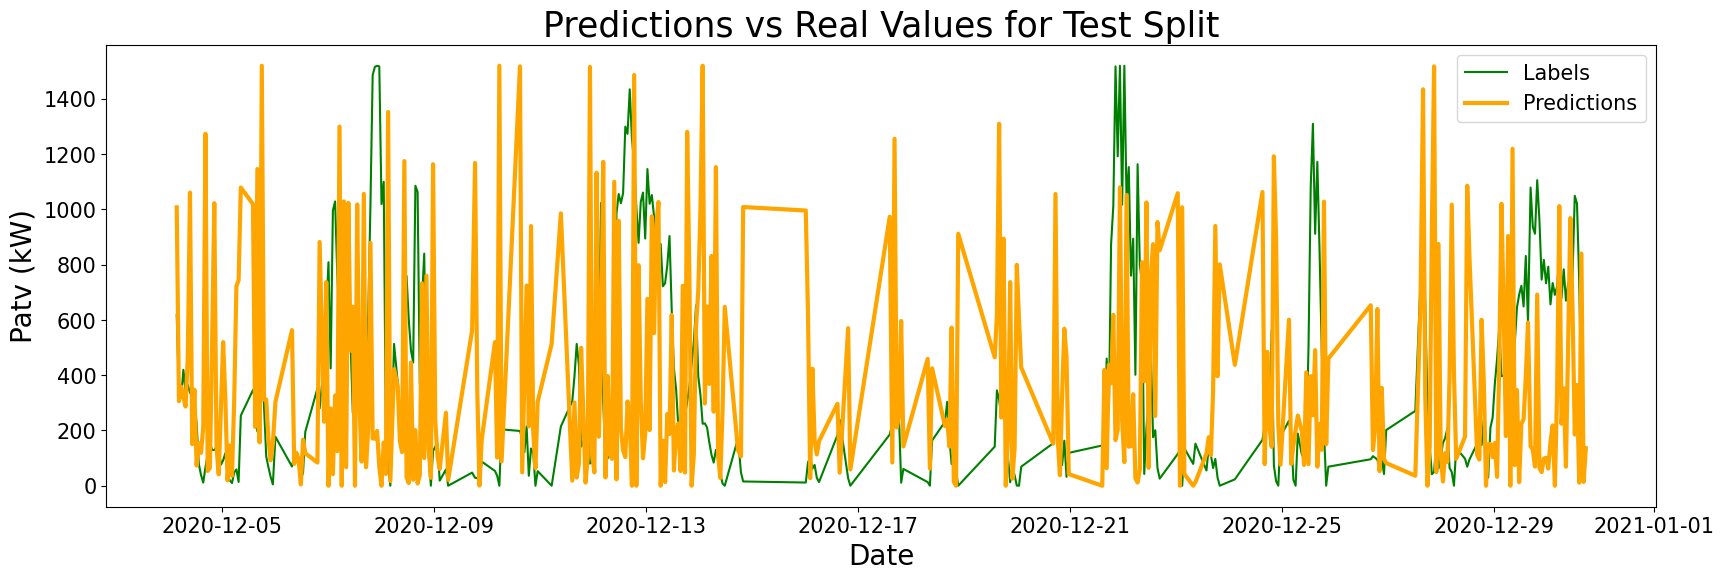

In [95]:
# Compute the random baseline
random_window, random_baseline = random_forecast(data_splits)

# Plot the predicted vs real values for the test split
random_baseline_mae = random_window.plot_long(random_baseline, data_splits)

### Replicate the last 24 hours (tomorrow == today)

simple baseline which consists of using the previous day to predict the next one,

This compute and shows a plot of actual vs predicted values along with some performance metrics. Note that the slider is set to 24 hours in the future, but you can change it to predict for earlier times (in other words you can say for example: "I predict the power output in 17 hours to be the same as now").

In [96]:
def repeat_forecast(
    data_splits: DataSplits, shift: int = 24
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """
    Implements a repeated forecasting logic where the last observed value 
    in the input window is used as the forecast for future time steps.

    Args:
        data_splits (DataSplits): Encapsulated training, validation, and testing datasets.
        shift (int, optional): Number of time steps into the future to forecast. Defaults to 24.

    Returns:
        tuple: A configured WindowGenerator instance and the RepeatBaseline model.
    """
    # Extract training, validation, and testing datasets
    train_data, val_data, test_data = (
        data_splits.train_data,  # Training data
        data_splits.val_data,    # Validation data
        data_splits.test_data,   # Testing data
    )

    # Generate a windowed dataset with a shift of `shift` timesteps
    repeat_window = generate_window(train_data, val_data, test_data, 1, shift)

    # Define a custom TensorFlow model for the repeat baseline
    class RepeatBaseline(tf.keras.Model):
        def call(self, inputs):
            """
            Repeats the last value from the input window as the prediction.

            Args:
                inputs (tf.Tensor): Input data for the model.

            Returns:
                tf.Tensor: Predictions based on the last value of the input.
            """
            return inputs[:, :, -1:]  # Select the last feature across the input window

    # Instantiate the RepeatBaseline model
    repeat_baseline = RepeatBaseline()

    # Compile the model with a loss function and evaluation metrics
    repeat_baseline.compile(
        # Minimize the squared error between predictions and true values
        loss=tf.keras.losses.MeanSquaredError(),
        # Track mean absolute error during evaluation
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    # Return the windowed dataset and the repeat baseline model
    return repeat_window, repeat_baseline

In [97]:
def interact_repeat_forecast(
    data_splits: DataSplits, baseline_mae: float
) -> None:
    """
    Creates an interactive visualization of predictions vs true values using a repeat baseline model.

    Args:
        data_splits (DataSplits): Encapsulated training, validation, and testing datasets.
        baseline_mae (float): Mean Absolute Error (MAE) of a baseline model for comparison.
    """

    def _plot(shift):
        """
        Inner function to update the plot dynamically based on the selected shift value.

        Args:
            shift (int): Number of hours into the future to forecast.
        """
        # Generate a repeat forecast for the specified shift
        repeat_window, repeat_baseline = repeat_forecast(
            data_splits, shift=shift)

        # Use the `plot_long` method from the WindowGenerator instance to visualize predictions
        _ = repeat_window.plot_long(
            repeat_baseline,  # The repeat baseline model
            data_splits,      # Encapsulated dataset
            baseline_mae=baseline_mae,  # Baseline MAE for comparison
        )

    # Create an interactive slider to select the shift (number of hours into the future)
    shift_selection = widgets.IntSlider(
        value=24,  # Default shift is 24 hours
        min=1,     # Minimum shift value is 1 hour
        max=24,    # Maximum shift value is 24 hours
        step=1,    # Step size for the slider is 1 hour
        description="Hours into future",  # Label for the slider
        disabled=False,  # Slider is enabled
        continuous_update=False,  # Update plot only when the slider is released
        orientation="horizontal",  # Horizontal slider layout
        readout=True,  # Show the numeric value of the slider
        readout_format="d",  # Display the value as an integer
        layout={"width": "500px"},  # Set the width of the slider
        # Style adjustments for label alignment
        style={"description_width": "initial"},
    )

    # Create an interactive visualization using the `_plot` function and the shift slider
    interact(_plot, shift=shift_selection)

In [98]:
# Create a model by predicting the next 24 hours of wind power will be the same as the previous 24 hours
interact_repeat_forecast(data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### Compute a moving average

The next baseline is a moving average and consists of averaging the last `n_days` to obtain a prediction for a future value. For this baseline you can select the time horizon into the future that you want to predict so at any given time step if you select 1 hour into the future you will use the previous 24 hours to predict the next hour. If you select 15 hours into the future you will use the previous 24 hours to generate the value for 15 hours into the future. Here you can also change the `n_days` parameter in the code to include a longer past period into the average.

This code implements a moving average forecast for a time series dataset. It utilizes a TensorFlow-based baseline model that forecasts future values by repeating the average of past values over a specified number of days (n_days).

In [99]:
# Moving average forecast
def moving_avg_forecast(data_splits: DataSplits, n_days: int) -> Tuple[WindowGenerator, tf.keras.Model]:
    """
    Implements a moving average forecast logic.

    Args:
        data_splits (DataSplits): Contains train, validation, and test datasets.
        n_days (int): Number of time steps (days) for calculating the moving average.

    Returns:
        tuple: 
            - The windowed dataset (`moving_avg_window`).
            - A baseline model (`moving_avg_baseline`) implementing the moving average forecast.
    """
    # Unpack the training, validation, and testing data from the DataSplits object
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )

    # Generate a window of size `n_days` for moving average logic
    moving_avg_window = generate_window(
        train_data, val_data, test_data, n_days)

    # Define a custom TensorFlow model for the moving average baseline
    class avgBaseline(tf.keras.Model):
        """
        A TensorFlow model that implements moving average forecasting logic.
        """

        def call(self, inputs):
            """
            Forward pass of the model.
            Args:
                inputs (tf.Tensor): Input time series data.
            
            Returns:
                tf.Tensor: Forecasted values based on the moving average.
            """
            # Compute the mean along the time axis (axis=1)
            m = tf.math.reduce_mean(inputs, axis=1)

            # Repeat the mean value for the number of time steps in the input
            stacked = tf.stack([m for _ in range(inputs.shape[1])], axis=1)

            # Extract only the last column (assumes forecasting one feature)
            return stacked[:, :, -1:]

    # Instantiate the moving average baseline model
    moving_avg_baseline = avgBaseline()

    # Compile the model with loss and metrics
    moving_avg_baseline.compile(
        # Use Mean Squared Error (MSE) as the loss function
        loss=tf.keras.losses.MeanSquaredError(),
        # Include Mean Absolute Error (MAE) as a metric
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    # Return the windowed dataset and the compiled baseline model
    return moving_avg_window, moving_avg_baseline

In [100]:
# an interactive visualization of model predictions versus true values for a time series dataset.
def prediction_plot(
    func: Callable, model: tf.keras.Model, data_splits: DataSplits, baseline_mae: float
) -> None:
    """
    Creates an interactive plot to visualize predictions vs. true values for a time series model.

    Args:
        func (Callable): The function used to create the plot (likely `plot_long` from the WindowGenerator class).
        model (tf.keras.Model): The trained model to generate predictions.
        data_splits (DataSplits): Data containing training, validation, and testing splits, along with normalization info.
        baseline_mae (float): The baseline model's MAE for comparison purposes.
    """

    def _plot(time_steps_future):
        """
        Inner function to generate the plot for a specific time step in the future.
        
        Args:
            time_steps_future (int): Number of hours into the future for which to visualize predictions.
        """
        mae = func(
            model,
            data_splits,
            time_steps_future=time_steps_future,  # Pass the slider value
            baseline_mae=baseline_mae,           # Baseline MAE for comparison
        )

    # Create an interactive slider widget for selecting hours into the future
    time_steps_future_selection = widgets.IntSlider(
        value=24,                 # Default value: 24 hours
        min=1,                    # Minimum value: 1 hour
        max=24,                   # Maximum value: 24 hours
        step=1,                   # Step size: 1 hour
        description="Hours into future",  # Label for the slider
        disabled=False,           # Enable the slider
        continuous_update=False,  # Update plot only when slider stops moving
        orientation="horizontal",  # Display slider horizontally
        readout=True,             # Show the current value
        readout_format="d",       # Format value as an integer
        layout={"width": "500px"},         # Set the width of the slider
        style={"description_width": "initial"},  # Adjust description styling
    )

    # Link the slider to the _plot function for interactive updates
    interact(_plot, time_steps_future=time_steps_future_selection)

In [101]:
# Compute the baseline 
moving_avg_window, moving_avg_baseline = moving_avg_forecast(
    data_splits, n_days=1)

# Plot the predicted vs real values for the test split
prediction_plot(moving_avg_window.plot_long, moving_avg_baseline,
                      data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## Train neural network models using historical data


### Look at example input and output sequences

train a model that learns patterns in the data in order to make predictions, or more specifically, a model that attempts to learn from the past to predict the future.

code defines a function, create_model, which creates a Convolutional-LSTM (Conv-LSTM) model using TensorFlow/Keras. The model is designed to specifically predict the next 24 hours based on historical time series data.

Purpose:

Builds a sequential neural network model for time series prediction.
Combines Convolutional Neural Networks (CNNs) for local pattern extraction with LSTMs (Long Short-Term Memory networks) for sequential learning.



In [102]:
def create_model(num_features: int, days_in_past: int) -> tf.keras.Model:
    """
    Creates a Conv-LSTM model for time series prediction.

    Args:
        num_features (int): Number of features used for prediction (input dimensionality).
        days_in_past (int): Number of days into the past used to predict the next 24 hours.

    Returns:
        tf.keras.Model: The uncompiled Keras model.
    """
    # Define constants
    CONV_WIDTH = 3  # Number of timesteps to use for convolution
    # Number of timesteps to predict into the future (next 24 hours)
    OUT_STEPS = 24

    # Create a Sequential model
    model = tf.keras.Sequential(
        [
            #Masking layer to ignore padding values (-1.0) in the input sequences
            tf.keras.layers.Masking(
                mask_value=-1.0,
                # Input shape: (timesteps, features)
                input_shape=(days_in_past * 24, num_features)
            ),

            # Lambda layer to extract only the last `CONV_WIDTH` timesteps from the input
            # This reduces the focus to the most recent data points
            tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),

            # Conv1D layer to extract local patterns from the last `CONV_WIDTH` timesteps
            # - Uses a kernel size of `CONV_WIDTH` to look at small time windows
            # - Produces 256 feature maps with ReLU activation
            tf.keras.layers.Conv1D(
                256, activation="relu", kernel_size=(CONV_WIDTH)
            ),

            # First Bidirectional LSTM layer with 32 units
            # - Processes sequential information in both forward and backward directions
            # - Returns sequences for use in the next layer
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(32, return_sequences=True)
            ),

            # Second Bidirectional LSTM layer with 32 units
            # - Processes the sequence further and outputs the final hidden state
            # - `return_sequences=False` means only the last timestep's output is kept
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(32, return_sequences=False)
            ),

            # Dense layer to predict all 24 timesteps (OUT_STEPS)
            # - Outputs a flat array of size `OUT_STEPS * 1` (since we're predicting a single value per timestep)
            # - Initializes weights to zero for stable training at the start
            tf.keras.layers.Dense(
                OUT_STEPS * 1, kernel_initializer=tf.initializers.zeros()
            ),

            # Reshape the flat output into the shape [OUT_STEPS, 1]
            # - Each timestep now has one predicted value
            tf.keras.layers.Reshape([OUT_STEPS, 1]),
        ]
    )

    # Return the uncompiled model
    return model

This code defines a utility function compile_and_fit to compile and train a TensorFlow/Keras model on a windowed dataset. It includes mechanisms to prevent overfitting using early stopping, which halts training if the validation loss does not improve after a specified number of epochs (patience).

In [103]:
#Function to compile and fit model
def compile_and_fit(
    model: tf.keras.Model, window: WindowGenerator, patience: int = 2
) -> tf.keras.callbacks.History:
    """
    Compiles and trains a TensorFlow/Keras model with early stopping.

    Args:
        model (tf.keras.Model): The model to be compiled and trained.
        window (WindowGenerator): Provides windowed training and validation datasets.
        patience (int, optional): Number of epochs to wait for an improvement 
                                  in validation loss before stopping training. Defaults to 2.

    Returns:
        tf.keras.callbacks.History: Contains the training and validation loss history.
    """
    # Number of training epochs
    EPOCHS = 20

    # Define the EarlyStopping callback
    # - Monitors validation loss (`val_loss`)
    # - Stops training if the validation loss does not improve for `patience` epochs
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=patience,   # Number of epochs to wait for improvement
        # Stop when the validation loss decreases (minimization)
        mode="min"
    )

    # Compile the model
    model.compile(
        # Use Mean Squared Error (MSE) as the loss function
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),    # Use the Adam optimizer
    )

    # Set random seeds for reproducibility
    tf.random.set_seed(432)
    np.random.seed(432)
    random.seed(432)

    # Train the model
    history = model.fit(
        window.train,                # Training dataset provided by WindowGenerator
        epochs=EPOCHS,               # Maximum number of training epochs
        validation_data=window.val,  # Validation dataset
        # Use early stopping to prevent overfitting
        callbacks=[early_stopping]
    )

    # Check if training stopped early
    if len(history.epoch) < EPOCHS:
        print(
            "\nTraining stopped early to prevent overfitting, as the validation loss "
            "is increasing for two consecutive steps."
        )

    # Return the training history
    return history

This code defines a function train_conv_lstm_model to train a Conv-LSTM  model for time series prediction. It follows a systematic workflow: splitting the data, creating windows, building the model, compiling it, and training it.


Function Purpose:

Trains a Conv-LSTM model to predict the next 24 hours of a time series based on historical data.
Uses features provided in the data DataFrame to generate forecasts.

In [ ]:
def train_conv_lstm_model(
    data: pd.core.frame.DataFrame, features: List[str], days_in_past: int
) -> Tuple[WindowGenerator, tf.keras.Model, DataSplits]:
    """
    Trains the Conv-LSTM model for time series prediction.

    Args:
        data (pd.core.frame.DataFrame): The input DataFrame containing time series data.
        features (list[str]): List of feature column names to use for forecasting.
        days_in_past (int): Number of days in the past to use as input for predicting the next 24 hours.

    Returns:
        tuple:
            - window (WindowGenerator): Windowed dataset used for training, validation, and testing.
            - model (tf.keras.Model): The trained Conv-LSTM model.
            - data_splits (DataSplits): Contains train, validation, and test data splits.
    """
    #  Split the data into training, validation, and testing sets.
    data_splits = train_val_test_split(data[features])

    #  Unpack the data splits and their statistics.
    train_data, val_data, test_data, train_mean, train_std = (
        data_splits.train_data,  # Normalized training data
        data_splits.val_data,    # Normalized validation data
        data_splits.test_data,   # Normalized testing data
        # Training set mean (used for de-normalization)
        data_splits.train_mean,
        data_splits.train_std,   # Training set standard deviation
    )

    # Create a windowed dataset for time series forecasting.
    # to create sequences based on the number of past days (`days_in_past`).
    window = generate_window(train_data, val_data, test_data, days_in_past)

    #Determine the number of features in the training dataset.
    # This is required to define the input shape of the Conv-LSTM model.
    num_features = window.train_df.shape[1]

    # Create the Conv-LSTM model.
    model = create_model(num_features, days_in_past)

    #Compile and train the model.
    # The `compile_and_fit` function compiles the model (with MSE loss and Adam optimizer),
    # applies early stopping, and trains the model on the windowed dataset.
    history = compile_and_fit(model, window)

    #Return the windowed dataset, trained model, and original data splits.
    return window, model, data_splits

In [105]:
# Now using all features
features = list(data.columns)

# Compute the forecasts
window, model, _data_splits = train_conv_lstm_model(
    data, features, days_in_past=1)

# Plot the predicted vs real values for the test split
prediction_plot(window.plot_long, model, _data_splits,
                      baseline_mae=random_baseline_mae)

Epoch 1/20
95/95 [==============================] - 5s 13ms/step - loss: 0.9251 - val_loss: 0.9474
Epoch 2/20
95/95 [==============================] - 0s 4ms/step - loss: 0.8733 - val_loss: 0.9501
Epoch 3/20
95/95 [==============================] - 0s 3ms/step - loss: 0.8617 - val_loss: 0.9688

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## Include wind speed forecasts in the model

So far only historical data was used to predict future values. It turns out that doesn't work very well.

There were no weather forecasts included in the original SDWPF competition dataset, but in a real world wind power forecasting scenario, there will certainly have wind speed forecasts to be included in the modeling as well. 

In this case, a "synthetic" wind forecasts is created by simply including the next day's wind data in your set of predictors that previously only included historical data. Of course, this is unrealistic because there will never have perfect knowledge of what the wind will do in the future

### Train a neural network model using perfect wind speed forecasts


This code generates synthetic wind speed forecasts for a given DataFrame, simulating forecasts for various time periods into the future. 
Purpose:

Creates new columns in a DataFrame to represent synthetic wind speed forecasts, where period is the forecast horizon 
Adds optional noise to these forecasts, making them less accurate as the forecast horizon increases.

In [106]:
# function to generate synthetic wind speed
def add_wind_speed_forecasts(
    df: pd.core.frame.DataFrame, add_noise=False
) -> pd.core.frame.DataFrame:
    """
    Creates synthetic wind speed forecasts. Forecasts can optionally include noise, 
    increasing with the forecast period to simulate real-world uncertainty.

    Args:
        df (pd.core.frame.DataFrame): DataFrame containing wind speed data (`Wspd` column).
        add_noise (bool or str, optional): Specifies the type of noise to add:
            - "linearly_increasing": Adds noise proportional to the forecast horizon.
            - "mimic_real_forecast": Adds noise to mimic real-world forecasts.
            - False or unspecified: No noise is added.

    Returns:
        pd.core.frame.DataFrame: A new DataFrame with synthetic forecast columns added.
    """

    # Create a deep copy of the input DataFrame to avoid modifying the original
    df_2 = df.copy(deep=True)

    #Define the forecast periods (1 hour to 29 hours into the future)
    periods = [*range(1, 30, 1)]

    # Iterate over each forecast period to create synthetic forecasts
    for period in periods:

        # Add noise based on the specified method
        if add_noise == "linearly_increasing":
            # Linearly increasing noise: More noise as the forecast horizon increases
            np.random.seed(8752)  # Set seed for reproducibility
            noise_level = 0.2 * period  # Noise level proportional to the forecast horizon
            # Generate random noise
            noise = np.random.randn(len(df)) * noise_level

        elif add_noise == "mimic_real_forecast":
            # Noise mimicking real-world forecasts: Baseline noise + increment per horizon
            np.random.seed(8752)  # Set seed for reproducibility
            noise_level = 2 + 0.05 * period  # Baseline noise + incremental noise
            # Generate random noise
            noise = np.random.randn(len(df)) * noise_level

        else:
            # No noise added
            noise = 0

        #Create the forecasted values for the current period
        # - Shift the `Wspd` column backward by `period` steps
        # - Add padding for the missing values (last `period` values of `Wspd`)
        # - Add the generated noise (if any)
        # Extract last `period` values for padding
        padding_slice = df_2["Wspd"][-period:].to_numpy()
        values = np.concatenate(
            # Shift the data backward by `period`
            (df_2["Wspd"][period:].values, padding_slice)
        ) + noise  # Add noise to the forecast

        # Add the forecast column (`fc-{period}h`) to the DataFrame
        df_2[f"fc-{period}h"] = values

    # Return the updated DataFrame with synthetic forecasts
    return df_2

In [107]:
# Create a new dataframe with the perfect forecasts
data_with_perfect_wspd_forecasts = add_wind_speed_forecasts(data)

# Include all features along with the external forecasts
features = list(data_with_perfect_wspd_forecasts.columns)

# Compute the power output forecasts
window, model, _data_splits = train_conv_lstm_model(
    data_with_perfect_wspd_forecasts, features, days_in_past=1)

# Plot the predicted vs actual values for the test split
prediction_plot(window.plot_long, model, _data_splits,
                      baseline_mae=random_baseline_mae)

Epoch 1/20
95/95 [==============================] - 5s 14ms/step - loss: 0.7086 - val_loss: 0.5367
Epoch 2/20
95/95 [==============================] - 0s 3ms/step - loss: 0.4708 - val_loss: 0.4119
Epoch 3/20
95/95 [==============================] - 0s 3ms/step - loss: 0.3846 - val_loss: 0.3569
Epoch 4/20
95/95 [==============================] - 0s 4ms/step - loss: 0.3290 - val_loss: 0.3258
Epoch 5/20
95/95 [==============================] - 0s 3ms/step - loss: 0.2943 - val_loss: 0.3297
Epoch 6/20
95/95 [==============================] - 0s 3ms/step - loss: 0.2723 - val_loss: 0.3568

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…